<div class="frontmatter text-center">
<img src="Multi_gauss.jpg" width="600px"/>
<h1> Finite Gaussian Mixture Models <br></h1>
</div>

# Clustering with Gaussian mixtures

## One dimensional Gaussian mixtures with EM

Our data is just points along one dimensions, but coming from K Gaussian distributions. It means that we have one variable about one property, and we have several objects/data points and we do not know to which cluster they belong, i.e. from which Gaussian distribution they are coming from. Here we use a Maximum likelihhod estimate to infer the unknown classes of the objects/data points.

<img src="gaussMix_1D.png" width="400px"/>

### Generating data with known parameters

Here, we have just one property, 4 classes, and 200 data points/objects. The data points are generated from 4 different Gaussian distributions with certain means and variance. Our objective is to infer the clusters or groups for the the data points/objects. Thus we want to infer the paramters of the Gaussian distributions from which the data was generated, and to infer for each data point that to which cluster they belong.

First, we set these known parameters: $\mu$ - vector of the means; $\Sigma$ - the vector of the variances

In [1]:
# Importing modules
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy as sc
from scipy import random, linalg, stats, special

In [2]:
# parameters
NProperties = 1
NClasses = 4
NObjects = 200
symmetric_dirichlet = 1
distanceBTWclasses = 20
DiffBTWSpreadOFclasses = 2

# The mean vector
Mu = [np.random.random(NProperties)*distanceBTWclasses*i for i in range(1,NClasses+1)]
# the sd vector
Var = [np.random.random(NProperties)*DiffBTWSpreadOFclasses*i for i in range(1,NClasses+1)]

In order to generate data from these classes along this one property we need to define a probability distribution over the classes. That will be a multinomial distribution, which have the parameter $\omega$ which is a vector of the probability of each class.

The data generation:
* (1) We take samples from the dirichlet distribution which is either symmetric or not. It as one parameter: $\alpha$. This sample will be the $\omega$ values for the multinomial distribution;
* (2) We generate the number of points in the classes with the parameter $\omega$ from the multinomial distribution;
* (3) We generate the given number of points from our Gaussian distributions for each classes with the previously defined $\mu$ and $\Sigma$ vectors.

<img src="DGen2.bmp" width="300px"/>

In [3]:
# (1)
# we can have symmetric dirichlet that put a same amount of probability to each classes appearance probability

if symmetric_dirichlet==1:
    theta = np.repeat(1.0/NClasses,NClasses)
else:
    a = np.ones(NClasses)
    n = 1
    p = len(a)
    rd = np.random.gamma(np.repeat(a,n),n,p)
    rd = np.divide(rd,np.repeat(np.sum(rd),p))
    theta = rd

print 'The probabilities of each classes from 1 to '+str(NClasses)
print theta

The probabilities of each classes from 1 to 4
[ 0.25  0.25  0.25  0.25]


In [4]:
# (2)
# generate the class from a multinomial distribution with parameter theta
r = np.random.multinomial(NObjects,theta)

print 'The number of objects in each classes from 1 to '+str(NClasses)
print r

The number of objects in each classes from 1 to 4
[50 52 52 46]


In [5]:
# (3)
rAlln = [np.random.normal(Mu[i], Var[i], r[i]) for i in range(0,NClasses)]

We plot our data points/objects

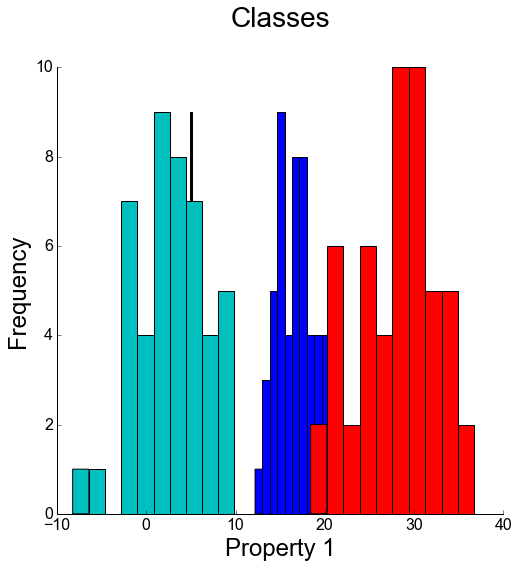

In [6]:
# plot parameters
plotsize = 8
bins = 10
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
for i in range(0,NClasses):
    ax.hist(rAlln[i], 10, color=color[i])

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Frequency', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('Classes', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize,plotsize)

plt.show()

### Learning the parameters and infer the latent classes of an object

First, we organize our data and introduce a latent variable $V$ which represents the classes of the objects/data points, that we do not know, and we want to infer it.

We also make a vector with the true classes in order to know the grand truth about each points/objects.

In [7]:
# putting the generated data into an array form
y = rAlln[0]
for i in range(NClasses-1):
    y = np.hstack((y,rAlln[i+1]))

# Getting the true classes of the points 
v_true = np.zeros((1)) 
for i,j in enumerate(r):
    v_true = np.hstack((v_true, np.repeat(i+1, j)))

v_true = np.array(v_true[1:])
y_true = np.vstack((y, v_true))

# random shuffle the data points
np.random.shuffle(y_true.T)

y = y_true[0,:]

print 'The data:'
print y

The data:
[  4.91581255e+00   1.97977586e+01   5.11514741e+00   3.04050453e+01
   5.34721723e+00   3.10177030e+01   2.95237147e+01   2.55137581e+01
   1.46221170e+00   2.63824752e+01   2.81135151e+01  -1.15728754e+00
   1.33398327e+01   2.14533137e+01   5.08458770e+00   1.84078867e+01
   2.16218225e+01  -8.59769762e-01   8.14029615e+00   1.53196483e+01
   2.04196833e+01   2.01387373e+01   4.73401415e+00   4.68313629e+00
   2.79535495e+01   8.14108636e+00   3.29474508e+01   5.28897806e+00
   4.92574364e+00   1.37712188e+01   1.85243585e+01  -5.68099144e+00
   4.98740662e+00   1.75198699e+01   5.06293511e+00   2.71714202e+01
   2.00565258e+00   5.02876659e+00   1.69285800e+01   1.76229369e+01
   9.86617323e+00   1.43158944e+01   2.49974586e+00   1.90497877e+00
   3.32124384e+01   1.83025559e+01   4.79815241e+00   3.67411393e+01
   1.44815867e+01   1.57058401e+01   3.37476377e+01   4.87050353e+00
  -2.51186612e+00   4.82532449e+00   1.89039703e+01   4.72562914e-01
   6.44741567e+00   5.10

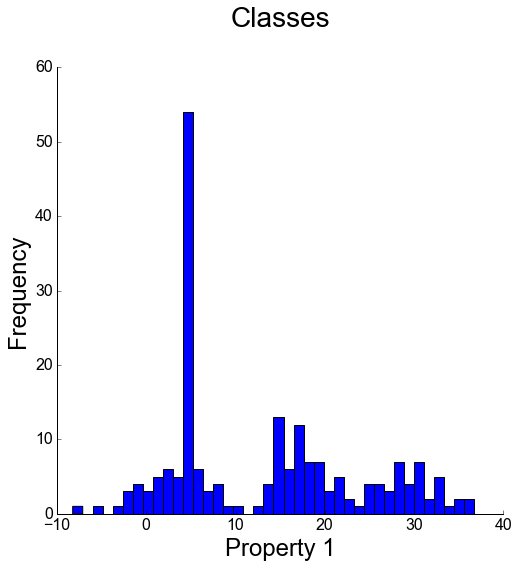

In [8]:
# plot parameters
plotsize = 8
bins = 40
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.hist(y,bins)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Frequency', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('Classes', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize,plotsize)

plt.show()

The above figure shows how the data looks like if we do not know the clusters.

In [9]:
# Definening V as a latent variable denoting the classes. V is set to random initially.
v = np.array([random.randint(1, NClasses+1) for i in range(y.shape[0])])

### Inference with EM algorithm

The EM algorithm has two steps.

Repeat until converged:
* E-step. Compute the expectations, or responsibilities $r_{j,i}$, of the latent variables $v_i$, where $j$ represents the classes, $y$ the data points, and $i$ the $ith$ points:
$$\begin{equation}
r_{j,i} = P(v_i = j~|~y_i)
\end{equation}
$$

* M-step. Compute the maximum likelihood parameters given these responsibilities:
$$\begin{equation}
\theta ← \arg\max_{ \theta} \sum_i \sum_j r_{j,i} (log P(v_i = j) + log P(y_i~|~v_i = j))
\end{equation}
$$


In our mixture of Gaussian the EM is the following.

Repeat until converged:
* E-step. Compute the expectations, or responsibilities $r_{j,i}$, of the latent variables $v_i$, where $j$ represents the classes, $y$ the data points, and $i$ the $ith$ points:
$$\begin{equation}
r_{j,i} = \frac{\omega_j P(y_i~|~\mu_j,\Sigma_j)}{\sum_j \omega_j P(y_i~|~\mu_j,\Sigma_j)}
\end{equation}
$$

* M-step. Compute the maximum likelihood parameters given these responsibilities:

    * (1) The weigths for the mixing proportions, $\omega_j$, where $N$ is the number of data points:
    The estimate of the probability of a class as an outcome is the proportion of times it appears:
$$\begin{equation}
\omega_j ← \arg\max \sum_i \sum_j r_{j,i} log P(z_i = j) = \sum_i \sum_j r_{j,i} log \omega_j = \frac{1}{N}\sum_i r_{j,i}
\end{equation}
$$

    * (2) The means and the variances for the Gauss distributions, $\mu_j$, $\sigma_j$ :
    We want to maximize this term:
$$\begin{equation}
\arg\max \sum_i r_{j,i} log P(y_i~|~v_i = j) = \sum_i r_{j,i} log Gaussian(y_i; \mu_j, \sigma_j)
\end{equation}
$$
$$\begin{equation}
\mu_j ←  \frac{1}{\sum_i r_{j,i}} \sum_i r_{j,i} y_i
\end{equation}
$$
$$\begin{equation}
\sigma_j ←  \frac{1}{\sum_i r_{j,i}} \sum_i r_{j,i} (y_i - \mu_j)^2
\end{equation}
$$

#### Let's define some starting values for the EM.
The means should not be the same because the algorithm stuck in that state, thus one should use random values for the means and broad SD.

In [10]:
broadness = 15
initMu = np.random.random(NClasses)*max(y)
initVar = np.random.random(NClasses)+broadness
initW = theta #np.random.random(NClasses)
#initW = initW / np.sum(initW)

#### Functions implementing the EM steps

In [13]:
def EStep(y, w, Mu, Sigma):
    
    r_ij = np.zeros((y.shape[0], Mu.shape[0]))
    
    for Object in range(y.shape[0]):
        
        r_ij_Sumj = np.zeros(Mu.shape[0])
        
        for jClass in range(Mu.shape[0]):
            r_ij_Sumj[jClass] = w[jClass] * sc.stats.norm.pdf(y[Object], Mu[jClass], np.sqrt(Sigma[jClass]))
        
        for jClass in range(r_ij_Sumj.shape[0]):
            r_ij[Object,jClass] =   r_ij_Sumj[jClass] / np.sum(r_ij_Sumj)
        
    return r_ij

In [14]:
r_n = EStep(y, initW, initMu, initVar)
print r_n

[[  9.50575784e-01   3.79284000e-14   7.90434425e-04   4.86337818e-02]
 [  8.70758251e-04   2.03424902e-04   7.00598584e-01   2.98327233e-01]
 [  9.44762898e-01   5.59723833e-14   9.42097422e-04   5.42950050e-02]
 [  3.63041122e-09   9.28387994e-01   7.08325335e-02   7.79468607e-04]
 [  9.37177054e-01   8.79661494e-14   1.15475105e-03   6.16681945e-02]
 [  1.13204577e-09   9.59798376e-01   3.98475910e-02   3.54031771e-04]
 [  1.85003725e-08   8.43020560e-01   1.54665222e-01   2.31419951e-03]
 [  4.78905148e-06   8.43512156e-02   8.63757884e-01   5.18861112e-02]
 [  9.93132289e-01   4.17634108e-17   3.59353428e-05   6.83177585e-03]
 [  1.89357632e-06   1.83270374e-01   7.81930955e-01   3.47967770e-02]
 [  1.96337426e-07   5.65310059e-01   4.24322894e-01   1.03668508e-02]
 [  9.98482920e-01   2.29823801e-19   3.40600589e-06   1.51367379e-03]
 [  9.82618422e-02   6.80402484e-08   1.89101037e-01   7.12637053e-01]
 [  2.09771901e-04   1.27179599e-03   8.03868755e-01   1.94649677e-01]
 [  9.

In [15]:
def MStep(r, y, Mu, Sigma):
    
    N = y.shape[0]
    
    mu_j = np.zeros((N, Mu.shape[0]))
    sigma_j = np.zeros((N, Mu.shape[0]))
    
    for Object in range(y.shape[0]):
        
        # mean
        mu_j[Object,:] = r[Object,:] * y[Object]
        
        # sd
        sigma_j[Object,:] = r[Object,:] * np.square(-Mu + y[Object])

    w_j = np.sum(r, axis=0) / N
    mu_j = (1/np.sum(r, axis=0)) * np.sum(mu_j, axis=0)
    sigma_j = (1/np.sum(r, axis=0)) * np.sum(sigma_j, axis=0)
    
    return w_j,mu_j,sigma_j

In [16]:
w_n,mu_n,sigma_n = MStep(r_n, y, initMu, initVar)

print w_n
print mu_n
print sigma_n

[ 0.46743887  0.13928899  0.2164213   0.17685084]
[  3.92614983  31.13019893  20.85705015  14.97572203]
[ 11.94386127  26.6653159   21.32606203  20.49623066]


#### Lets implement the EM algorithm

In [17]:
Inititeration = 10
EMiteration = 200
lookLH = 20

for init in range(Inititeration):
    
    # starting values
    initMu = np.random.random(NClasses)*max(y)
    r_n = EStep(y, initW, initMu, initVar)
    w_n,mu_n,sigma_n = MStep(r_n, y, initMu, initVar)
    
    if init == 0:
        logLH = -1000000000000
        
    for i in range(EMiteration):

        # E step
        r_n = EStep(y, w_n, mu_n, sigma_n)

        # M step
        w_n,mu_n,sigma_n = MStep(r_n, y, mu_n, sigma_n)

        # compute log likelihood
        logLall = np.zeros((y.shape[0]))

        for Object in range(y.shape[0]):

            LH = np.zeros(NClasses)

            for jClass in range(NClasses):
                LH[jClass] = w_n[jClass] * sc.stats.norm.pdf(y[Object], mu_n[jClass], np.sqrt(sigma_n[jClass]))

            logLall[Object] = np.log(np.sum(LH))

        logL = np.sum(logLall)

        if i > EMiteration - lookLH:
            print logL

    if logL > logLH:
        logLH = logL
        print 'found larger: ', logLH
        w_p = w_n
        mu_p = mu_n
        sigma_p = sigma_n
        r_p = r_n

-697.049997906
-697.048758713
-697.047627321
-697.04658269
-697.045607681
-697.044688428
-697.043813765
-697.04297475
-697.042164241
-697.041376553
-697.040607174
-697.039852524
-697.039109771
-697.038376673
-697.037651457
-697.036932719
-697.036219349
-697.035510467
-697.034805373
found larger:  -697.034805373
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
-610.12855883
found larger:  -610.12855883
-697.90103695
-697.899085482
-697.897092436
-697.895056132
-697.892974822
-697.890846694
-697.88866986
-697.886442359
-697.884162152
-697.881827111
-697.879435025
-697.876983586
-697.874470387
-697.871892919
-697.86924856
-697.866534573
-697.863748095
-697.860886137
-697.857945567
-696.973833179
-696.97324811
-696.972664848
-696.9720834
-696.971503769
-696.97092596
-696.970349977
-696.9697

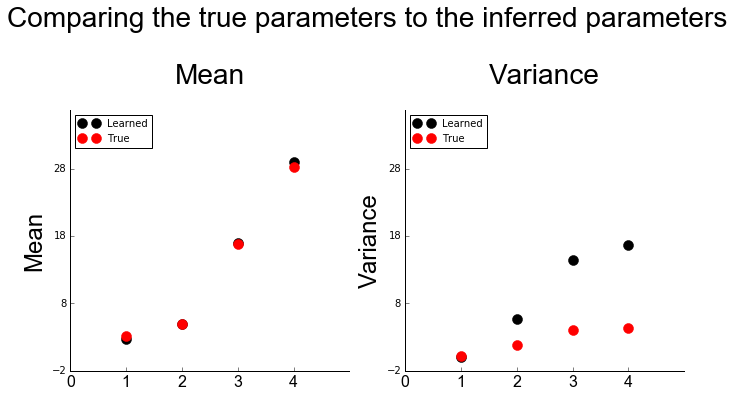

In [18]:
Mu_inf = np.sort(mu_p)
Mu_true = np.sort([Mu[i][0] for i in range(len(Mu))])

Var_inf = np.sort(sigma_p)
Var_true = np.sort([Var[i][0] for i in range(len(Var))])

# the figures
# parameters
plotsize = 11
sizeMean = 20
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}
x = range(1,NClasses+1)
startx = 0
endx = 5
stepsizex = 1
starty = -2
endy = max(y)
stepsizey = 10

# figure
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
#means
ax1.plot(x, Mu_inf, 'k.', markersize=sizeMean, label='Learned')
ax1.plot(x, Mu_true, 'r.', markersize=sizeMean, label='True')
#means
ax2.plot(x, Var_inf, 'k.', markersize=sizeMean, label='Learned')
ax2.plot(x, Var_true, 'r.', markersize=sizeMean, label='True')
          
for label in (ax1.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks(np.arange(startx, endx, stepsizex))
ax1.yaxis.set_ticks(np.arange(starty, endy, stepsizey))
ax1.set_xlim([startx, endx])
ax1.set_ylim([starty, endy])
ax1.set_ylabel('Mean', **axis_font)
ax1.legend(loc='upper left',fontsize=text_size-6)
ax1.set_title('Mean', y=1.08, **Title_font)
ax1.figure.set_size_inches(plotsize,plotsize)

for label in (ax2.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks(np.arange(startx, endx, stepsizex))
ax2.yaxis.set_ticks(np.arange(starty, endy, stepsizey))
ax2.set_xlim([startx, endx])
ax2.set_ylim([starty, endy])
ax2.set_ylabel('Variance', **axis_font)
ax2.legend(loc='upper left',fontsize=text_size-6)
ax2.set_title('Variance', y=1.08, **Title_font)
ax2.figure.set_size_inches(plotsize,plotsize)

plt.suptitle('Comparing the true parameters to the inferred parameters',**Title_font)
fig.subplots_adjust(top=0.85)
plt.show()

In [21]:
print 'The inferred parameters'
print 'Mixing proportion: ',w_p
print 'Means: ',mu_p
print 'Variances: ',sigma_p

The inferred parameters
Mixing proportion:  [ 0.22891002  0.26962079  0.27929343  0.22217575]
Means:  [ 28.92035589   5.01505599  17.04079384   2.7095824 ]
Variances:  [ 14.51388027   0.02494455   5.67228814  16.63062144]


In [22]:
print 'The True parameters'
print 'Mixing proportion: ',theta
print 'Means: ',Mu
print 'Variances: ',Var

The True parameters
Mixing proportion:  [ 0.25  0.25  0.25  0.25]
Means:  [array([ 16.8895807]), array([ 4.96940558]), array([ 28.23110153]), array([ 3.21975404])]
Variances:  [array([ 1.83692073]), array([ 0.17236288]), array([ 4.28928602]), array([ 3.98282186])]


In [35]:
GoodOrder = [2,1,0,3]
r_ordered = r_p[:,GoodOrder] 
infClusters = np.argmax(r_ordered, axis=1)
Clustering = y_true[1]==infClusters+1
print 'Clustering accuracy: ',np.mean(Clustering)

Clustering accuracy:  0.935


<img src="jm1.jpg" width="600px"/>


## N dimensional Gaussian mixtures with EM

Here, we generalize the previous EM algorithm to N properties which means that we will use multivariate Gaussian distributions instead of univariate. 

Now, we have N objects which have X properties. This is the observed data, so N observed points, called objects with X properties i.e each is an X dimensional vector. The objects/data points are coming from J multivariate Gaussian distributions with different mean vectors and Covariance matrices.

Again, our goal is to group them into K latent classes. So we do not know which object belongs to which groups, we will infer that from the data based on the properties of the objects. 

<img src="Multi_gauss.jpg" width="400px"/>

First, let us generate the data with known paramters. We assume that we have 6 latent classes, 4 observed properties, and 200 objects. We assume that in a class each properties are distributed as a Gaussian random variable with a certain mean and variance. Thus to generate data, we need a $\mu$ matrix, that stores the means of all the 4 properties for the 6 classes and 6 $\Sigma$ matrices.

### Data generation with known parameters

In the same way as before, in order to generate data from these classes with these properties we need to define a probability distribution over the classes.
We know that it will be a multinomial distribution, which have the parameter $\omega$ which is a vector of the probability of each class.

In the data generation:
* (1) We take samples from the dirichlet distribution which is either symmetric or not, the sample will be the $\omega$ paramter for the multinomial distribution
* (2) We generate the number of points in the classes with the parameter $\omega$ from the multinomial distribution
* (3) We generate the given number of points from our multivariate gaussian distributions for each classes. So each point is a vector with as many dimensions as many properties we have

<img src="DGen2.bmp" width="300px"/>

In [2]:
# function that generates positive symmetric definite matrices
def PosSymDefMatrix(n,sd):
    M = np.matrix(np.random.rand(n,n))
    M = 0.5*(M + M.T)
    M = M + sd*np.eye(n)
    return M

In [3]:
#parameters
NProperties = 4
NClasses = 6
NObjects = 150 # apparantly this is some limit for the gamma function so either take the logarithm of the input of the gamma function or the data points should be less than 170
symmetric_dirichlet = 1
distanceBTWclasses = 10

## Generating data with known parameters
# parameters of the mean and the covariance of the 6 NFeature dimensional gaussian

# The mean matrix
Mu = [(np.random.random(NProperties)*distanceBTWclasses*i) for i in range(1,NClasses+1)]

# generating symmetric positive semi-definite matrix for the covariances
sdDiff = 4
SDClass = np.random.rand(1,NClasses)+sdDiff

#Cov = [np.absolute(np.triu((np.dot(np.random.randn(NProperties,NProperties)*i,(np.random.randn(NProperties,NProperties)*i).transpose())))) for i in SDClass[0]]
#Cov = [np.maximum(cov, cov.transpose()) for cov in Cov]
Cov = [PosSymDefMatrix(NProperties,i) for i in SDClass[0]]

print 'the means of the properties for the classes'
for i in range(0,NClasses):
    print ['The means for Class ' + str(i+1)], Mu[i]
print '\n'
for i in range(0,NClasses):
    print ['the variance for Class ' + str(i+1)]
    print Cov[i]

the means of the properties for the classes
['The means for Class 1'] [ 6.40359918  3.28895826  0.82787782  9.77772544]
['The means for Class 2'] [ 18.20927878   0.76485995  12.99657225   2.69334549]
['The means for Class 3'] [ 22.69860004   2.77431784  25.14634791   3.95704242]
['The means for Class 4'] [  6.41542318  33.5107421   37.91141468  18.92333929]
['The means for Class 5'] [ 39.90258366  18.73952179  30.44372276  14.0395294 ]
['The means for Class 6'] [ 54.6639604   24.5064236   35.43680812  57.06636255]


['the variance for Class 1']
[[ 4.50850954  0.509713    0.46602145  0.34963675]
 [ 0.509713    4.95329826  0.38595481  0.45402722]
 [ 0.46602145  0.38595481  4.47972244  0.50181557]
 [ 0.34963675  0.45402722  0.50181557  4.46924082]]
['the variance for Class 2']
[[ 4.8938064   0.55739993  0.88953318  0.25809983]
 [ 0.55739993  4.6737915   0.14671276  0.31791227]
 [ 0.88953318  0.14671276  4.80280576  0.69118897]
 [ 0.25809983  0.31791227  0.69118897  5.26207588]]
['the vari

In [4]:
# (1)
# we can have symmetric dirichlet that put a same amount of probability to each classes appearance probability
symmetric_dirichlet = 1

if symmetric_dirichlet==1:
    theta = np.repeat(1.0/NClasses,NClasses)
else:
    a = np.ones(NClasses)
    n = 1
    p = len(a)
    rd = np.random.gamma(np.repeat(a,n),n,p)
    rd = np.divide(rd,np.repeat(np.sum(rd),p))
    theta = rd

print 'The probabilities of each classes from 1 to '+str(NClasses)
print theta

The probabilities of each classes from 1 to 6
[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]


In [5]:
# (2)
# generate the class from a multinomial distribution with parameter theta
r = np.random.multinomial(NObjects,theta)

print 'The number of objects in each classes from 1 to '+str(NClasses)
print r

The number of objects in each classes from 1 to 6
[24 28 26 20 28 24]


In [6]:
# (3)
rAlln = [np.random.multivariate_normal(Mu[i], Cov[i], r[i]) for i in range(0,NClasses)]

Let's plot the first two proterties of our 200 objects

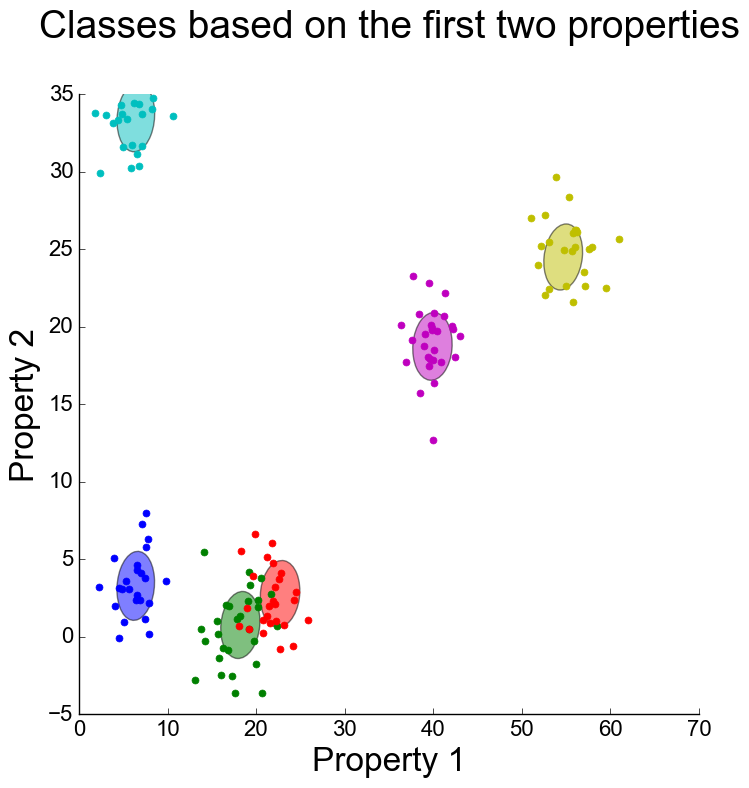

In [7]:
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
for i in range(NClasses):
      
    # the sd with ellipses
    # central point of the error ellipse
    pos = [Mu[i][0],Mu[i][1]]

    # for the angle we need the eigenvectors of the covariance matrix
    w,ve = np.linalg.eig(Cov[i][0:2,0:2])

    # We pick the largest eigen value
    order = w.argsort()[::-1]
    w = w[order]
    ve = ve[:,order]

    # we compute the angle towards the eigen vector with the largest eigen value
    thetaO = np.degrees(np.arctan(ve[1,0]/ve[0,0]))

    # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
    width, height = 2 * np.sqrt(w)

    # making the ellipse
    ellip = Ellipse(xy=pos, width=width, height=height, angle=thetaO)
    ellip.set_alpha(0.5)
    ellip.set_facecolor(color[i])
             
    ax.plot(rAlln[i][:,0],rAlln[i][:,1], '.', c=color[i], markersize=sizeMean)
    ax.add_artist(ellip)
        
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('Classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize,plotsize)

plt.show()

### Learning the parameters and infer the latent classes of an object

Again, we set our data, and make a vector with the classes in order to know the grand truth about each points/objects.

In [8]:
# putting the generated data into an array form
y = np.empty([1, NProperties])
for i in range(NClasses):
    y = np.vstack((y,rAlln[i]))
    
y = np.delete(y, 0, axis=0)

# Getting the true classes of the points 
v_true = np.zeros((1)) 
for i,j in enumerate(r):
    v_true = np.hstack((v_true, np.repeat(i+1, j)))

v_true = np.array([v_true[1:]])
y_true = np.concatenate((y, v_true.T), axis=1)

# random shuffle the data points
np.random.shuffle(y_true)

y = y_true[:,0:-1]

print 'The data:'
print y

The data:
[[  1.38004521e+01   4.92476032e-01   1.24621929e+01   4.73197826e+00]
 [  5.09759863e+01   2.70146273e+01   3.87740090e+01   5.67012607e+01]
 [  1.75688482e+01  -3.62199275e+00   7.10917073e+00   8.24352972e-01]
 [  5.94449133e+01   2.24933436e+01   3.63104576e+01   5.87643689e+01]
 [  3.95547928e+01   1.74774710e+01   3.26731786e+01   1.26368104e+01]
 [  1.69585460e+01   2.01330016e+00   1.25759028e+01   1.44918526e+00]
 [  1.66336699e+01   2.07991093e+00   1.37020786e+01   1.22823593e+00]
 [  7.95354137e+00   2.20860010e+00   2.54198172e+00   1.43165652e+01]
 [  7.93701427e+00   1.89784235e-01  -7.00295592e-01   1.00028466e+01]
 [  6.58774606e+00   2.68940108e+00   2.17256020e-01   9.59798119e+00]
 [  5.52721292e+01   2.83962493e+01   3.35304023e+01   5.63047171e+01]
 [  6.17661550e+00   3.44594532e+01   3.59166179e+01   1.76900287e+01]
 [  4.04552946e+01   1.97072175e+01   2.89146500e+01   1.54243260e+01]
 [  3.05267627e+00   3.36762887e+01   3.80961556e+01   2.14047041e+

Let us plot the data again in order to see whether our manipulaton with y left the data intact. We could also observe in this figure how the data looks like if we would not know the clusters.

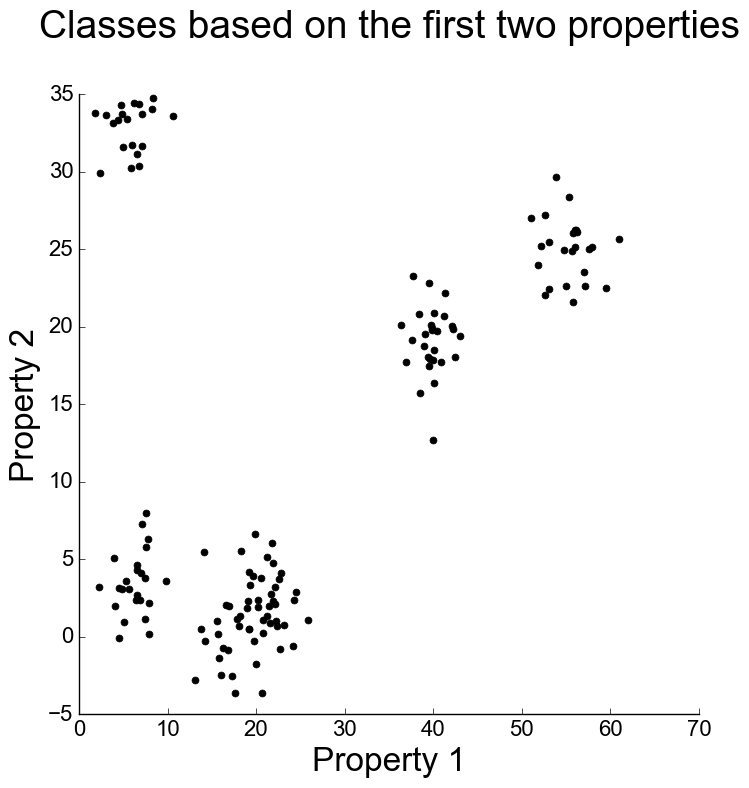

In [9]:
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.plot(y[:,0],y[:,1], 'k.', markersize=sizeMean)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('Classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize,plotsize)

plt.show()

Again, we also create a latent variable, that represents the class labels.

In [10]:
# for random classes
v = np.array([random.randint(1, NClasses+1) for i in range(y.shape[0])])

### The inference with EM algorithm.

#### Let's define some starting values for the EM
The means should not be the same because the algorithm stuck in that state, thus one should use random values for the means and broad variance.

In [45]:
broadness = 2

initMu = np.empty([NClasses, NProperties])
initCov = np.empty([NProperties, NProperties, NClasses])

for j in range(NClasses):
    
    initMu[j,:] = np.random.random(NProperties)*np.amax(y, axis=0)
    initCov[:,:,j] = np.mean(np.array(Cov), axis=0)+broadness
    
initW = theta

#### Functions implementing the EM steps

In [46]:
def EStep(y, w, mu, cov):
    
    r_ij = np.zeros((y.shape[0], mu.shape[0]))

    for Object in range(y.shape[0]):
        
        r_ij_Sumj = np.zeros(mu.shape[0])
        
        for jClass in range(mu.shape[0]):
            
            r_ij_Sumj[jClass] = w[jClass] * sc.stats.multivariate_normal.pdf(y[Object,:], mu[jClass,:], cov[:,:,jClass])
        
        for jClass in range(r_ij_Sumj.shape[0]):
            r_ij[Object,jClass] =   r_ij_Sumj[jClass] / np.sum(r_ij_Sumj)
    
    return r_ij

In [47]:
r_n = EStep(y, initW, initMu, initCov)
print r_n

[[  3.09695729e-077   1.00000000e+000   6.33184218e-019   9.94469190e-016
    1.63130971e-015   9.40410713e-029]
 [  1.04048003e-054   3.93669724e-020   4.66122252e-001   5.33877748e-001
    2.44832754e-099   3.74736380e-011]
 [  9.82838677e-045   7.32358257e-034   9.99999995e-001   5.17478297e-012
    1.25084000e-116   4.72032807e-009]
 ..., 
 [  1.57939610e-067   1.38066263e-008   5.46862849e-018   6.69624674e-012
    9.99999986e-001   2.93250932e-044]
 [  9.33723822e-065   9.99982111e-001   4.02506431e-009   1.65007502e-005
    1.38435394e-006   1.06787931e-019]
 [  1.33098274e-049   8.80138334e-032   9.99284431e-001   1.78820010e-008
    1.43681495e-110   7.15550953e-004]]


In [48]:
def MStep(r, y, mu, cov):
    
    N = y.shape[0]
    
    # the weigths
    w_j = np.sum(r, axis=0) / N
    
    Allmu_j = np.zeros((N, mu.shape[0], mu.shape[1]))
    Allcov_j = np.zeros((N, cov.shape[0], cov.shape[1], cov.shape[2]))
    
    # mean
    for Object in range(N):
        
        Allmu_j[Object,:,:] = np.outer(r[Object,:], y[Object,:])
    
    mu_j = np.zeros((mu.shape[0], mu.shape[1]))
    
    for j in range(cov.shape[2]):
        mu_j[j,:] = (1/np.sum(r, axis=0)[j]) * np.sum(Allmu_j, axis=0)[j,:]
        
    # sd
    for Object in range(N):
        for j in range(cov.shape[2]):
            Allcov_j[Object,:,:,j] = r[Object,j] * np.outer((y[Object,:] - mu_j[j,:]), (y[Object,:]-mu_j[j,:]))

    cov_j = np.zeros((cov.shape[0], cov.shape[1], cov.shape[2]))
    
    for j in range(cov.shape[2]):
        
        cov_j[:,:,j] = (1/np.sum(r, axis=0)[j]) * np.sum(Allcov_j, axis=0)[:,:,j]
    
    return w_j,mu_j,cov_j

In [49]:
w_n,mu_n,cov_n = MStep(r_n, y, initMu, initCov)
print w_n
print mu_n
print cov_n

[ 0.00972623  0.10564591  0.33761505  0.21304901  0.33281479  0.00114901]
[[  9.69994418  10.6572958   -3.93865732  39.10138748]
 [  1.48115405  11.50915903  13.65184478   8.62105323]
 [ 14.11305474  21.18342735  17.1626458   40.97989977]
 [ 23.47748346  25.06954646  25.48793683  25.03456368]
 [ 14.07520746  15.66477428  17.25233161   8.47241642]
 [  4.07313207  14.41754538  -2.52291546  38.99760366]]
[[[  1.10642634e+00   4.47260791e+00   3.71504508e+01   9.84563392e+00
     1.29204467e+02   3.36711518e+00]
  [ -1.56854236e-01  -1.13371201e+00   5.39957934e+01   4.07821409e+00
     1.47153088e+02   5.38178163e+00]
  [  2.68152928e-01   1.82929199e+00   9.25580097e+01   7.42314475e-01
     1.32588274e+02   9.78712401e+00]
  [ -9.97499510e-02   1.38441413e+00   1.43007829e+01  -2.35559906e+01
     7.40010616e-01   3.06190209e+00]]

 [[ -1.56854236e-01  -1.13371201e+00   5.39957934e+01   4.07821409e+00
     1.47153088e+02   5.38178163e+00]
  [  3.22249394e-01   1.21967760e+01   1.1790451

#### Lets implement the EM algorithm

In [50]:
Inititeration = 100
EMiteration = 40
lookLH = 20

for init in range(Inititeration):
    
    # starting values
    initMu = np.empty([NClasses, NProperties])
    for j in range(NClasses):
        initMu[j,:] = np.random.random(NProperties)*np.amax(y, axis=0)
        
    r_n = EStep(y, initW, initMu, initCov)
    w_n,mu_n,cov_n = MStep(r_n, y, initMu, initCov)
    
    if init == 0:
        logLH = -1000000000000
        
    for i in range(EMiteration):

        # E step
        r_n = EStep(y, w_n, mu_n, cov_n)

        # M step
        w_n,mu_n,sigma_n = MStep(r_n, y, mu_n, cov_n)

        # compute log likelihood
        logLall = np.zeros((y.shape[0]))

        for Object in range(y.shape[0]):

            LH = np.zeros(NClasses)

            for jClass in range(NClasses):
                LH[jClass] = w_n[jClass] * sc.stats.multivariate_normal.pdf(y[Object,:], mu_n[jClass,:], cov_n[:,:,jClass])

            logLall[Object] = np.log(np.sum(LH))

        logL = np.sum(logLall)

        if i > EMiteration - lookLH:
            print logL

    if logL > logLH:
        logLH = logL
        print 'found larger: ', logLH
        w_p = w_n
        mu_p = mu_n
        sigma_p = sigma_n
        r_p = r_n

-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
-2246.93348
found larger:  -2246.93348
-2227.25555093
-2227.25424171
-2227.25329095
-2227.25260427
-2227.25211039
-2227.25175632
-2227.25150311
-2227.25132237
-2227.25119357
-2227.25110188
-2227.25103668
-2227.25099034
-2227.25095744
-2227.25093408
-2227.2509175
-2227.25090575
-2227.25089741
-2227.2508915
-2227.25088731
found larger:  -2227.25088731
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2409.21588057
-2439.21585436
-2439.20772415
-2439.19852988
-2439.18864918
-2439.17862856
-2439.16908686
-2439.16057715
-2439.15346473
-2439.14787425
-2439.143717

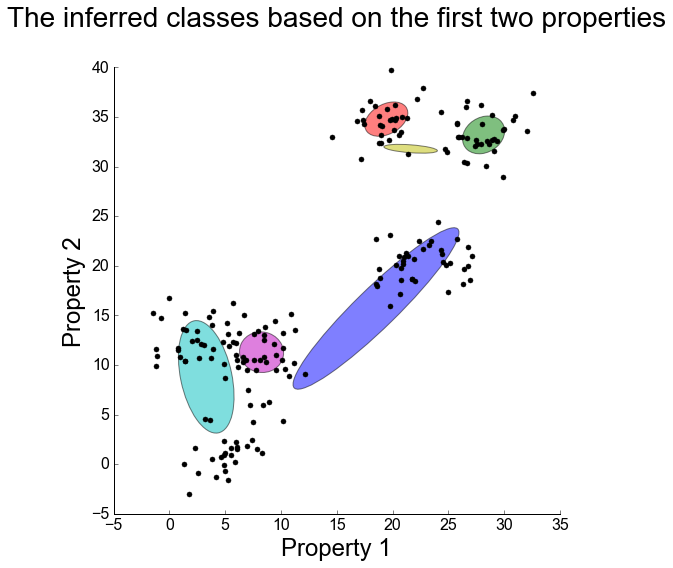

In [51]:
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.plot(y[:,0],y[:,1], 'k.', markersize=sizeMean)
for i in range(NClasses):
      
    # the sd with ellipses
    # central point of the error ellipse
    pos = [mu_p[i,0],mu_p[i,1]]

    # for the angle we need the eigenvectors of the covariance matrix
    w,ve = np.linalg.eig(sigma_p[0:2,0:2,i])

    # We pick the largest eigen value
    order = w.argsort()[::-1]
    w = w[order]
    ve = ve[:,order]

    # we compute the angle towards the eigen vector with the largest eigen value
    thetaO = np.degrees(np.arctan(ve[1,0]/ve[0,0]))

    # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
    width, height = 2 * np.sqrt(w)

    # making the ellipse
    ellip = Ellipse(xy=pos, width=width, height=height, angle=thetaO)
    ellip.set_alpha(0.5)
    ellip.set_facecolor(color[i])
             
    ax.add_artist(ellip)
        
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('The inferred classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize,plotsize)

plt.show()

In [64]:
print 'The inferred mixing proportions: ',w_p
print 'The True mixing proportions: ',theta

The inferred mixing proportions:  [ 0.2592773   0.16        0.14502552  0.2457227   0.175       0.01497448]
The True mixing proportions:  [ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]


In [65]:

for i in range(0,NClasses):
    print ['The Inferred means'], mu_p[i,:]
print '------------------'

for i in range(0,NClasses):
    print ['The True mean for Class' + str(i+1)], Mu[i]

['The Inferred means'] [ 18.51539451  15.69946234  14.22694937  19.96329436]
['The Inferred means'] [ 28.15595877  33.19484754  34.02944568   8.37963824]
['The Inferred means'] [ 19.44039217  34.78675581  40.76688032  50.27868281]
['The Inferred means'] [  3.30536071   8.80579141  10.99134813   8.40996627]
['The Inferred means'] [  8.26102665  11.29078992  -0.04520503  38.24398969]
['The Inferred means'] [ 21.62102617  31.79696962  41.99448277  50.55141787]
------------------
['The True mean for Class1'] [ 5.62350317  1.74271929  7.04422872  8.67078923]
['The True mean for Class2'] [  2.77219531  12.28019846  12.46517118   7.89214103]
['The True mean for Class3'] [ 22.0491188   20.40828755  16.72278955  23.25102071]
['The True mean for Class4'] [ 28.94479676  33.76917817  34.69132822   8.36509903]
['The True mean for Class5'] [  8.22580725  10.9135991    0.09851178  38.34953841]
['The True mean for Class6'] [ 20.15369452  34.13794958  40.64573039  50.4613162 ]


In [66]:
for i in range(0,NClasses):
    print ['the Inferred variances' ]
    print sigma_p[:,:,i]
print '------------------'
for i in range(0,NClasses):
    print ['the True variance for Class ' + str(i+1)]
    print Cov[i]

['the Inferred variances']
[[ 55.29833355  56.89132689  35.45477657  43.35448447]
 [ 56.89132689  66.2992232   40.67323569  51.46711774]
 [ 35.45477657  40.67323569  28.67423206  32.71891207]
 [ 43.35448447  51.46711774  32.71891207  45.64890448]]
['the Inferred variances']
[[ 3.55736807  0.75481046  1.00762847  0.90373746]
 [ 0.75481046  3.62099526  0.33871189 -0.82352433]
 [ 1.00762847  0.33871189  5.04667983  1.06150893]
 [ 0.90373746 -0.82352433  1.06150893  4.08793998]]
['the Inferred variances']
[[ 3.71709283  1.18153302  0.80735798 -0.07849239]
 [ 1.18153302  2.99068849  0.0736207   0.09165816]
 [ 0.80735798  0.0736207   3.82092599 -1.35535893]
 [-0.07849239  0.09165816 -1.35535893  7.99626066]]
['the Inferred variances']
[[  6.21473609  -4.97607056  -3.00621495   0.525814  ]
 [ -4.97607056  32.17175353  13.6356735    1.64023255]
 [ -3.00621495  13.6356735   11.43563338   0.60146514]
 [  0.525814     1.64023255   0.60146514   3.78057442]]
['the Inferred variances']
[[ 3.90236291

In [67]:
GoodOrder = [2,3,5,1,4,0]
r_ordered = r_p[:,GoodOrder] 
infClusters = np.argmax(r_ordered, axis=1)
Clustering = y_true[:,4]==infClusters+1
print 'Clustering accuracy: ',np.mean(Clustering)

Clustering accuracy:  0.5


It is remarkably bad isn't it? The EM algorithm finds the local minima, therefore we need to initialze several hundred times the algorithm with different inital values and take the most likely parameters in order to infer the clusters well.

<img src="jm2.jpg" width="600px"/>


## Multivariate Gaussian mixtures with Full Bayesian estimation with conjugate priors and Gibbs sampling

Finally, we implement a full Bayesian approach to our Gaussian clustering problem.

The data is the same as before:

$y$ - data points $N$x$X$

$\mu$ - Mean matrix $J$x$X$

$\Sigma$ - Covariance matrices $X$x$X$x$J$

Where $N$ is the number of data points, $X$ is the number of properties, and $J$ is the number of classes

Gibbs sampler is a frequently used MCMC algorithm, and is used here to estimate the model parameters.
We have the following parameters to estimate: $ \mu$ (the mean vectors), $\Sigma$ (the covariances), $\omega$ (the weights of the proportion of the the different classes), and $V$ (which is a latent variable representing the classes for the objects).
Gibbs sampler works by iteratively drawing samples from the full conditional posterior distributions of the parameters of interest.

### The Graphical model:

<img src="gen_mix_model.bmp" width="500px"/>

### The formal model:

With $i$ observations and $j$ classes

* #### The posterior:
$$\begin{equation}
P(\theta~|~y) \propto \prod_i\ P(y_i~|~\theta) P(\theta)
\end{equation}$$
    * Where the parameters are the following:
$$\begin{equation}
\theta = \mu , \Sigma , \omega , V
\end{equation}$$
* #### The likelihood:
$$\begin{equation}
P(y_i~|~\theta) = \sum_j\omega_j P(y_i~|~\mu_j,\Sigma_j)
\end{equation}$$
* #### Conjugate priors for the parameters ($P(\theta)$):
$$\begin{equation}
\Sigma_j \sim W^{-1} (m_j,\phi_j)
\end{equation}$$
    * The inverse Wishart distribution, with $m_j$ degrees of freedom and scale matrix $\phi_j$
$$\begin{equation}
\mu_j~|~\Sigma_j \sim N_M(\xi_j,\frac{\Sigma_j}{\sigma_j})
\end{equation}$$
    * The multivariate normal distribution with known covariance matrix $\frac{\Sigma_j}{\sigma_j}$, for some precision parameters $\sigma_j$
$$\begin{equation}
(\omega_1, \dots, \omega_j) \sim D(\alpha_1, \dots, \alpha_j)
\end{equation}$$
    * Dirichlet distribution with parameters $\alpha_j$

### The conditional posterior distributions:

* #### For the Covariances
$$\begin{equation}
\Sigma_j~|~y,V \sim W^{-1} (n_j + m_j,\phi_j + \Lambda_j + \frac{n_j \sigma_j}{n_j + \sigma_j} (\bar{y_j} - \xi_j)(\bar{y_j}- \xi_j)^t)
\end{equation}$$
    * Where, $ \Lambda_j = \sum_j(y_i - \bar{y_j})(y_i - \bar{y_j})^t $
    * And $ \bar{y_j} $ is the average of $y_i$ for a class $j$ 
    * The inverse Wishart distribution. The degrees of freedom equal the sum of the prior degrees of freedom $m_j$, and the number of observations in cluster $j$, $n_j$. The scale matrix has three components - the prior opinion of $\Sigma_j$, namely $\phi_j$, the sum of squares $\Lambda_j$, and the deviation between prior and estimated mean values

* #### For the Means
$$\begin{equation}
\mu_j~|~ y, \Sigma_j, V \sim N_M(\bar{\xi_j},\frac{\Sigma_j}{\sigma_j + n_j})
\end{equation}$$
    * Where, $ \bar{\xi_j} = \frac{\sigma_j\xi_j + n_j \bar{y_j}}{\sigma_j + n_j} $
    * The multivariate normal distribution. The mean vector $\bar{\xi_j}$ in the posterior distribution is a weighted sum of the prior and, by data, estimated mean values.

* #### For the Weights
$$\begin{equation}
P(\Omega~|~V) = \frac{\Gamma((\alpha_1 + \sum_i I(v_i=1)) + \dots + (\Gamma((\alpha_j + \sum_i I(v_i=j)))}{\Gamma((\alpha_1 + \sum_i I(v_i=1)) * \dots * (\Gamma((\alpha_j + \sum_i I(v_i=j)))} \prod_j \omega_j^{\alpha_j + \sum_i I(v_i=j)-1}
\end{equation}$$
    * Dirichlet distribution. The prior specification $\alpha_1, \dots, \alpha_j,$ and the classification of the observations $I(v_i=j)$ ;$i = 1,\dots, n $ ; $j = 1, \dots , J$

* #### For the points belonging to class $j$
$$\begin{equation}
t_{ij}~|~ \mu_j, \Sigma_j, \Omega = \frac{\omega_j P(y_i~|~\mu_j,\Sigma_j)}{\sum_j \omega_j P(y_i~|~\mu_j,\Sigma_j)}
\end{equation}$$
    * The posterior probability $t_{ij}$ for observation $y_i$, to belong to cluster $j $. We can see that it is the same as the responsibilities in the EM algorithm ( $r_{ij}$)

### Define the prior parameters

In [68]:
priorMu = np.empty([1, NProperties])
priorPhi = np.empty([NProperties, NProperties])
for i in range(NClasses):
    priorMu = np.vstack((priorMu, np.mean(np.array(Mu), axis=0)))
    priorPhi = np.dstack((priorPhi, np.mean(np.array(Cov), axis=0)))
    

priorMu = np.delete(priorMu, 0, axis=0)
priorPhi = np.delete(priorPhi, 0, axis=2)
priorPhi = priorPhi*2
priorM = np.repeat(2, NClasses)
priorSigma = np.ones(NClasses)
priorAlpha = np.ones(NClasses)

### Functions computing the conditional posteriors

* #### For the Covariances

* With preallocation

In [69]:
def cov_new(y, v, priorM, priorPhi, priorMu, priorSigma):
    
    cov = np.zeros(priorPhi.shape)
    
    for jClass in range(priorMu.shape[0]):
        
        index = v[:] == jClass+1
        y_i = y[index,:]
        y_iMean = np.mean(y_i, axis=0)
        
        n_j = y_i.shape[0]
        
        Sqr = np.zeros((priorPhi.shape[0],priorPhi.shape[1],n_j))
        for i in range(n_j):
            yDev = y_i[i,:] - y_iMean
            yOut = np.outer(yDev, yDev)
            Sqr[:,:,i] = yOut
            
        sumOfSqr = np.sum(Sqr, axis=2)
        
        priorDev = y_iMean - priorMu[jClass,:]
        devFromPrior = (n_j*priorSigma[jClass])/(n_j+priorSigma[jClass]) * np.outer(priorDev, priorDev)
        
        scale_j = priorPhi[:,:,jClass] + sumOfSqr + devFromPrior
        cov_new = sc.stats.invwishart.rvs(priorM[jClass]+n_j, scale_j)
        cov[:,:,jClass] = cov_new
        
    return cov

In [70]:
cov_n = cov_new(y,v,priorM,priorPhi,priorMu,priorSigma)
print cov_n

[[[  1.26247672e+02   1.02212382e+02   7.73301841e+01   7.96686076e+01
     1.05097086e+02   9.52726388e+01]
  [  1.45972483e+02   8.60039134e+01   8.69504996e+01   8.85350039e+01
     8.97831425e+01   7.91924417e+01]
  [  1.53030005e+02   9.24535606e+01   9.69395221e+01   9.45921407e+01
     1.08463068e+02   8.50636968e+01]
  [  3.27545134e+01  -7.19106241e+00   2.54683803e+00   3.20310484e+01
     4.19930223e+01   8.00030549e+00]]

 [[  1.45972483e+02   8.60039134e+01   8.69504996e+01   8.85350039e+01
     8.97831425e+01   7.91924417e+01]
  [  2.26118695e+02   1.12407463e+02   1.54709895e+02   1.41405127e+02
     1.45912193e+02   1.12464168e+02]
  [  2.34931852e+02   1.32860680e+02   1.77632705e+02   1.43417784e+02
     1.76417194e+02   1.29742937e+02]
  [  1.12041151e+02   1.75986468e+01   5.89047270e+01   9.22183225e+01
     1.04549789e+02   3.82479433e+01]]

 [[  1.53030005e+02   9.24535606e+01   9.69395221e+01   9.45921407e+01
     1.08463068e+02   8.50636968e+01]
  [  2.34931852

* #### For the Means

* With preallocation

In [71]:
def Mu_new(y, v, cov, priorMu, priorSigma):
    
    Mu = np.zeros(priorMu.shape)
    
    for jClass in range(priorMu.shape[0]):
        
        index = v[:] == jClass+1
        y_i = y[index,:]
        y_iMean = np.mean(y_i, axis=0)
        
        n_j = y_i.shape[0]
        
        mean = (priorMu[jClass,:]*priorSigma[jClass] + n_j*y_iMean) / (priorSigma[jClass] + n_j)
        covar = cov[:,:,jClass] / (priorSigma[jClass] + n_j)
        Mu_new = np.random.multivariate_normal(mean,covar)
        Mu[jClass,:] = Mu_new
    
    return Mu

In [72]:
mu_n = Mu_new(y, v, cov_n, priorMu, priorSigma)
print mu_n

[[ 16.89399167  25.49256172  23.390238    33.95976525]
 [ 11.53071713  16.43069235  17.07918524  24.09965295]
 [ 18.82347386  22.1775472   20.66884852  22.93959108]
 [ 14.91655292  18.0723332   20.43747931  20.88100823]
 [ 10.52141229  14.31435109  13.4946948   19.84340019]
 [ 14.74480146  20.25817039  19.37386292  25.03261805]]


* #### For the Weights

In [73]:
def W_new(y, v, priorAlpha):
    
    W = np.zeros(priorAlpha.shape[0])
    
    for jClass in range(priorAlpha.shape[0]):
        
        index = v[:] == jClass+1
        y_i = y[index,:]
        
        W[jClass] = y_i.shape[0] + priorAlpha[jClass]
        
    return np.random.dirichlet((W))

In [74]:
w_n = W_new(y, v, priorAlpha)
print w_n

[ 0.08718451  0.1283382   0.2561736   0.17535046  0.18454395  0.16840927]


* #### For the V classification vector

In [75]:
def probOfClass_new(y, w, mu, cov):
    
    T_ij = np.zeros((y.shape[0], mu.shape[0]))

    for Object in range(y.shape[0]):
        
        T_ij_Sumj = np.zeros(mu.shape[0])
        
        for jClass in range(mu.shape[0]):
            
            T_ij_Sumj[jClass] = w[jClass] * sc.stats.multivariate_normal.pdf(y[Object,:], mu[jClass,:], cov[:,:,jClass])
        
        for jClass in range(T_ij_Sumj.shape[0]):
            T_ij[Object,jClass] =   T_ij_Sumj[jClass] / np.sum(T_ij_Sumj)
    
    return T_ij

In [76]:
pr_n = probOfClass_new(y,w_n, mu_n, cov_n)
print pr_n

[[ 0.04018315  0.21372803  0.02722192  0.05562209  0.44686195  0.21638286]
 [ 0.11013935  0.07418794  0.2443563   0.18096293  0.18750949  0.20284398]
 [ 0.1322985   0.05600308  0.25501092  0.15161347  0.16573257  0.23934145]
 ..., 
 [ 0.03582258  0.10540388  0.08677778  0.58201233  0.15717503  0.03280841]
 [ 0.04772583  0.15019303  0.05940076  0.07109883  0.39187472  0.27970683]
 [ 0.23035998  0.02458723  0.28553205  0.16055981  0.16221707  0.13674386]]


In [77]:
def V_new(v, probOfClass):
    
    V = np.zeros((v.shape[0]))
    
    for Object in range(v.shape[0]):
        
        index = np.random.multinomial(1, probOfClass[Object,:])
        V[Object] = np.where(index==1)[0]+1
        
    return V

In [78]:
v_n = V_new(v, pr_n)
print v_n

[ 5.  5.  1.  6.  3.  3.  4.  6.  4.  3.  3.  4.  4.  6.  3.  2.  5.  5.
  1.  4.  2.  5.  5.  3.  6.  3.  5.  4.  1.  6.  1.  1.  6.  4.  4.  5.
  3.  6.  2.  3.  4.  5.  3.  3.  3.  5.  3.  5.  3.  1.  3.  3.  4.  4.
  3.  3.  6.  1.  5.  3.  5.  3.  6.  3.  6.  5.  5.  2.  5.  3.  6.  5.
  4.  4.  2.  1.  6.  3.  3.  6.  2.  4.  5.  3.  3.  5.  2.  4.  5.  5.
  6.  2.  2.  5.  3.  3.  6.  2.  2.  3.  4.  2.  3.  2.  1.  3.  2.  6.
  3.  6.  3.  5.  5.  6.  4.  1.  4.  1.  4.  2.  1.  3.  4.  5.  3.  5.
  1.  3.  6.  4.  4.  5.  6.  2.  6.  3.  5.  3.  2.  5.  3.  1.  6.  3.
  4.  4.  2.  4.  2.  4.  4.  3.  6.  6.  3.  6.  4.  3.  3.  5.  4.  5.
  6.  2.  4.  2.  2.  3.  6.  3.  6.  3.  6.  1.  2.  3.  2.  4.  3.  5.
  5.  4.  3.  3.  3.  6.  3.  4.  6.  3.  3.  4.  3.  5.  1.  4.  4.  3.
  5.  1.]


### Applying the Gibbs sampling

* With preallocation

In [79]:
iteration = 2000
burnIn = 400

# iteration 0
cov_n = cov_new(y,v,priorM,priorPhi,priorMu,priorSigma)
mu_n = Mu_new(y, v, cov_n, priorMu, priorSigma)
w_n = W_new(y, v, priorAlpha)
pr_n = probOfClass_new(y, w_n, mu_n, cov_n)
v_n = V_new(v, pr_n)

## Iterations
# the samples of the paramaters (comment out the undesired the parameter)

cov_post = np.zeros((cov_n.shape[0],cov_n.shape[1],cov_n.shape[2],iteration - burnIn))
mu_post = np.zeros((mu_n.shape[0],mu_n.shape[1],iteration - burnIn))
w_post = np.zeros((w_n.shape[0],iteration - burnIn))
pr_post = np.zeros((pr_n.shape[0],pr_n.shape[1],iteration - burnIn))
v_post = np.zeros((v_n.shape[0],iteration - burnIn))

# parameters for the try
ntry = 0

while True:
    
    ntry = ntry+1
    
    print 'try: ', ntry
    
    try:
        
        # iteration 0
        cov_n = cov_new(y,v,priorM,priorPhi,priorMu,priorSigma)
        mu_n = Mu_new(y, v, cov_n, priorMu, priorSigma)
        w_n = W_new(y, v, priorAlpha)
        pr_n = probOfClass_new(y, w_n, mu_n, cov_n)
        v_n = V_new(v, pr_n)
        
        for i in range(iteration):

            # Updateing the parameters
            cov_n = cov_new(y,v_n,priorM,priorPhi,priorMu,priorSigma)
            mu_n = Mu_new(y, v_n, cov_n, priorMu, priorSigma)
            w_n = W_new(y, v_n, priorAlpha)
            pr_n = probOfClass_new(y, w_n, mu_n, cov_n)
            v_n = V_new(v_n, pr_n)

            if i>burnIn:

                # saving the conditional posteriors samples for the parameters (comment out the undesired parameter)
                v_post[:,i-burnIn] = v_n
                cov_post[:,:,:,i-burnIn] = cov_n
                mu_post[:,:,i-burnIn] = mu_n
                w_post[:,i-burnIn] = w_n
                pr_post[:,:,i-burnIn] = pr_n
        break
            
    except ValueError:            
        print 'Oops! Another try..'

try:  1


C:\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda2\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Oops! Another try..
try:  2
Oops! Another try..
try:  3
Oops! Another try..
try:  4
Oops! Another try..
try:  5


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars


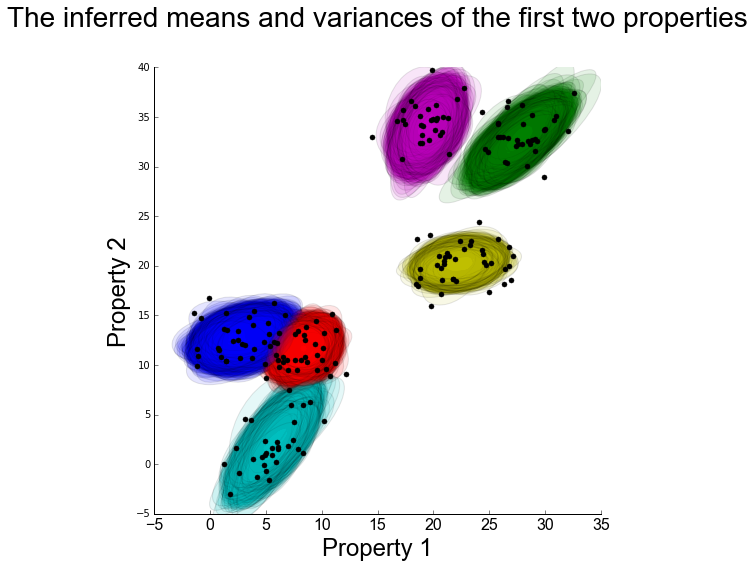

In [80]:
# the figures
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

for i in range(mu_post.shape[2]):
    for j in range(NClasses):

        # the sd with ellipses
        # central point of the error ellipse
        pos = [mu_post[j,0,i],mu_post[j,1,i]]

        # for the angle we need the eigenvectors of the covariance matrix
        w,ve = np.linalg.eig(cov_post[0:2,0:2,j,i])

        # We pick the largest eigen value
        order = w.argsort()[::-1]
        w = w[order]
        ve = ve[:,order]

        # we compute the angle towards the eigen vector with the largest eigen value
        theta = np.degrees(np.arctan(ve[1,0]/ve[0,0]))

        # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
        width, height = 2 * np.sqrt(w)

        # making the ellipse
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta)
        ellip.set_alpha(0.1)
        ellip.set_facecolor(color[j])

        # the mean
        ax1.plot(mu_n[j,0],mu_n[j,1], '.', c=color[j], markersize=sizeMean)
        ax1.add_artist(ellip)
        
ax1.plot(y[:,0],y[:,1], 'k.', markersize=sizeMean)
for label in (ax1.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_ylabel('Property 2', **axis_font)
ax1.set_xlabel('Property 1', **axis_font)
ax1.set_title('The inferred means and variances of the first two properties', y=1.08, **Title_font)
ax1.figure.set_size_inches(plotsize,plotsize)

plt.show()

This model gives us a quite good estimate for the underlying distributions.

In [93]:
print 'The inferred mixing proportions: ',np.mean(w_post, axis=1)
print 'The True mixing proportions: 0.166'

The inferred mixing proportions:  [ 0.16258483  0.16010153  0.17389544  0.14645861  0.16140674  0.19492785]
The True mixing proportions: 0.166


In [83]:
for i in range(0,NClasses):
    print ['The Inferred means'], np.mean(mu_post, axis=2)[i,:]
print '------------------'

for i in range(0,NClasses):
    print ['The True mean for Class' + str(i+1)], Mu[i]

['The Inferred means'] [  2.93953168  12.7124291   13.05618522   8.96357276]
['The Inferred means'] [ 27.69668208  32.73527162  33.51504458   8.81321523]
['The Inferred means'] [  8.43839245  11.48966337   0.47927511  37.78273191]
['The Inferred means'] [ 5.7102647   2.14229664  6.85194461  8.8831186 ]
['The Inferred means'] [ 19.47816019  34.02243109  40.20372985  49.43810102]
['The Inferred means'] [ 22.33148251  20.20523691  17.11445971  23.58608225]
------------------
['The True mean for Class1'] [ 5.62350317  1.74271929  7.04422872  8.67078923]
['The True mean for Class2'] [  2.77219531  12.28019846  12.46517118   7.89214103]
['The True mean for Class3'] [ 22.0491188   20.40828755  16.72278955  23.25102071]
['The True mean for Class4'] [ 28.94479676  33.76917817  34.69132822   8.36509903]
['The True mean for Class5'] [  8.22580725  10.9135991    0.09851178  38.34953841]
['The True mean for Class6'] [ 20.15369452  34.13794958  40.64573039  50.4613162 ]


In [84]:
for i in range(0,NClasses):
    print ['the Inferred variances' ]
    print np.mean(cov_post, axis=3)[:,:,j]
print '------------------'
for i in range(0,NClasses):
    print ['the True variance for Class ' + str(i+1)]
    print Cov[i]

['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.5942

In [117]:
GoodOrder = [2,4,5,1,6,3]
clusters = np.mean(v_post, axis=1)
clusters = np.round(clusters)
infClust = np.zeros(len(clusters))

for i,j in enumerate(GoodOrder):
    index = clusters==i+1
    infClust[index] = j
    
Clustering = y_true[:,4]==infClust
print 'Clustering accuracy: ',np.mean(Clustering)

Clustering accuracy:  0.995


<img src="jm3.jpg" width="600px"/>


## Multivariate Gaussian mixtures with Full Bayesian estimation with hyperparameters

We implement a more complex full Bayesian approach to our Gaussian clustering problem.

The data is the same as before:

$y$ - data points $N$x$X$

$\mu$ - Mean matrix $J$x$X$

$\Sigma$ - Covariance matrices $X$x$X$x$J$

Where $N$ is the number of data points, $X$ is the number of properties, and $J$ is the number of classes

### The Graphical model:

<img src="gen_mix_model2.bmp" width="600px"/>

### The formal model:

With $i$ observations and $j$ classes

* #### The posterior:
$$\begin{equation}
P(\theta~|~y) \propto \prod_n\ P(y_n~|~\theta) P(\theta)
\end{equation}$$
    * Where the parameters are the following:
$$\begin{equation}
\theta = \mu , \Sigma , \omega , V
\end{equation}$$
* #### The likelihood:
$$\begin{equation}
P(y_n~|~\theta) = \sum_j\omega_j P(y_n~|~\mu_j,\Sigma_j)
\end{equation}$$
* #### Conjugate priors for the parameters $P(\theta)$:

    * For the $\mu_j$ the prior is  a multivariate normal $(N_M)$ with $\lambda_i$ and $R$. The hyper parameter $\lambda_i$ comes from a vague multivariate normal distribtuion, and $R$ comes from a Wishart distribution $(W)$

$$\begin{equation} \mu_j~|~\lambda_i,R \sim N_M(\lambda_{i},R^{-1})\end{equation}$$ 

$$\begin{equation} \lambda_i~|~\xi_i,\sigma \sim N_M(\xi_i,\sigma)\end{equation}$$

$$\begin{equation} R~|~dfM_j,covM_j \sim W (dfM_j,covM_j)\end{equation}$$

+ The prior for the $\Sigma_j$ is a Wishart distribution, with $\beta$ the degrees of freedom and scale matrix $\Phi_j$. The hyper parameter $\beta$ is a scalar with a Gamma ($G$) prior on $(\beta-D+1)^{-1}$, where $D$ is the dimensions of the properties, i.e. number of properties, and $\Phi_j$ comes from a Wishart distribution $(W)$   

$$\begin{equation} \Sigma_j~|~\beta,\Phi_j \sim W(\beta,\Phi_j^{-1})\end{equation}$$

$$\begin{equation} (\beta-D+1)^{-1}~|~\beta \sim G(1,\beta)\end{equation}$$

$$\begin{equation} \Phi_j~|~dfS_j,\phi_j \sim W (dfS_j,\phi_j)\end{equation}$$

+ Finally, the priors on the weigths or mixing proportions come from a  Dirichlet distribution with parameters $\alpha_j$ 

$$\begin{equation} (\omega_1, \dots, \omega_j) \sim D(\alpha_1, \dots, \alpha_j)\end{equation}$$

### The conditional posterior distributions:

* #### For the Means
$$\begin{equation}
\mu_j~|~ y,V,\Sigma_j,\lambda,R \sim N_M(\bar{\Psi_j},\frac{1}{\Sigma_j * n_j + R})
\end{equation}$$
    * Where, $ \bar{\Psi_j} = \frac{\bar{y_j}*\Sigma_j*n_j + \lambda*R}{\Sigma_j * n_j +R} $
    * The conditional posterior for $ \lambda $ is also a multivariate normal distribution.   
$$\begin{equation}
\lambda_i~|~ \mu_j,R,\sigma \sim N_M(\frac{\xi_i*\sigma^{-2} + R * \sum_j\mu_{ji}}{\sigma^{-2} + J*R},\frac{1}{\sigma^{-2} + J*R})
\end{equation}$$
    * The conditional posterior for $ R $ is a Wishart distribution.   
$$\begin{equation}
R~|~ \mu_j,\lambda,\sigma \sim W(J+1,[\frac{1}{J+1}*(\sigma^{2}+\sum_j(\mu_j-\lambda)^{2})]^{-1})
\end{equation}$$

* #### For the Covariances
$$\begin{equation}
\Sigma_j~|~y,V,\mu_j,\beta,\Phi_j \sim W (\beta + n_j,[\frac{1}{n_j + \beta}*(\Phi_j*\beta + \Upsilon_j)]^{-1})
\end{equation}$$
    * Where, $ \Upsilon_j = \sum_j(y_i - \mu_j)(y_i - \mu_j)^t $
    * The conditional posterior for $ \Phi_j $ is also a a Wishart distribution.   
$$\begin{equation}
\Phi_j~|~\Sigma_j,\beta,\sigma \sim W (J*\beta+1, [\frac{1}{J*\beta+1} * (\sigma^{-2} + \beta* sum_j Sigma_j]^{-1})
\end{equation}$$
    * The conditional posterior for $ \beta $ is following.   
$$\begin{equation}
\beta~|~\Sigma_j,\Phi_j \propto \Gamma(\frac{\beta}{2})^{-J} * exp(\frac{-1}{2*\beta}) * \frac{\beta}{2})^{\frac{J*\beta - 3}{2}} \prod_j(\Sigma_j*\Phi_j)^{\frac{\beta}{2}} * exp(-\frac{\beta*\Sigma_j*\Phi_j}{2}))
\end{equation}$$
    * Here we will first transform $ \beta $ to $ log(\beta) $, then transform it back.

* #### For the Weights
$$\begin{equation}
P(\Omega~|~V) = \frac{\Gamma((\alpha_1 + \sum_i I(v_i=1)) + \dots + (\Gamma((\alpha_j + \sum_i I(v_i=j)))}{\Gamma((\alpha_1 + \sum_i I(v_i=1)) * \dots * (\Gamma((\alpha_j + \sum_i I(v_i=j)))} \prod_j \omega_j^{\alpha_j + \sum_i I(v_i=j)-1}
\end{equation}$$
    * The conditional prior on $V$ is the following.
$$\begin{equation}
V~|~\alpha = \frac{n_{-i,j} + \frac{\alpha}{J}}{N-1+\alpha}
\end{equation}$$
    * conditional posterior for $ \alpha $ is following.
$$\begin{equation}
\alpha~|~J,N \propto \frac{\alpha^{k-\frac{3}{2}} * exp(\frac{-1}{2*\alpha})*\Gamma(\alpha)}{\Gamma(N+\alpha)}
\end{equation}$$
    * Here, we will first transform $ \alpha $ to $ log(\alpha) $, then transform it back.

* #### For the points belonging to a class
$$\begin{equation}
t_{ij}~|~\mu_j,\Sigma_j,V,\alpha = \frac{P(V_j~|~\alpha) * P(y_i~|~\mu_j,\Sigma_j,V)}{\sum_j \omega_j P(y_i~|~\mu_j,\Sigma_j,V)}
\end{equation}$$
    * The posterior probability $t_{ij}$ for observation $y_i$, to belong to cluster $j $.
  

### Define the prior parameters

In [11]:
# priors for the mean
priorMu = np.mean(np.array(Mu), axis=0)
priorPrec = np.mean(np.array(Cov), axis=0)
InitR = priorPrec

InitLambda = np.random.multivariate_normal(priorMu, priorPrec)

InitCov = np.empty([NProperties, NProperties])
for i in range(NClasses):
    InitCov = np.dstack((InitCov, np.mean(np.array(Cov), axis=0)))

InitCov = np.delete(InitCov, 0, axis=2)

# priors for the covariances
InitBeta = np.random.gamma(1,1.0/NProperties,10000)
InitBeta = InitBeta + NProperties - 1
InitBeta = np.random.choice(InitBeta)

# prior on the weights
priorAlpha = 1

# starting value for mean vector AND covariance matrix # TODO is it ok to start somewhere?


### Functions computing the conditional posteriors

In [12]:
# using  John Grenall's code for adaptive rejection sampling

"""
Created on Fri Mar 27 06:46:02 2015
@author: John Grenall (original author), Alberto Lumbreras (reviewed and cleaned)
"""

import numpy as np
import random
from matplotlib import pyplot as plt

class ARS():
    '''
    This class implements the Adaptive Rejection Sampling technique of Gilks and Wild '92.
    Where possible, naming convention has been borrowed from this paper.
    The PDF must be log-concave.
    Currently does not exploit lower hull described in paper- which is fine for drawing
    only small amount of samples at a time.
    '''
    
    def __init__(self, f, fprima, xi=[-4,1,4], lb=-np.Inf, ub=np.Inf, use_lower=False, ns=50, **fargs):
        '''
        initialize the upper (and if needed lower) hulls with the specified params
        
        Parameters
        ==========
        f: function that computes log(f(u,...)), for given u, where f(u) is proportional to the
           density we want to sample from
        fprima:  d/du log(f(u,...))
        xi: ordered vector of starting points in wich log(f(u,...) is defined
            to initialize the hulls
        D: domain limits
        use_lower: True means the lower sqeezing will be used; which is more efficient
                   for drawing large numbers of samples
        
        
        lb: lower bound of the domain
        ub: upper bound of the domain
        ns: maximum number of points defining the hulls
        fargs: arguments for f and fprima
        '''
        
        self.lb = lb
        self.ub = ub
        self.f = f
        self.fprima = fprima
        self.fargs = fargs
        
        #set limit on how many points to maintain on hull
        self.ns = 50
        self.x = np.array(xi) # initialize x, the vector of absicassae at which the function h has been evaluated
        self.h = self.f(self.x, **self.fargs)
        self.hprime = self.fprima(self.x, **self.fargs)

        #Avoid under/overflow errors. the envelope and pdf are only
        # proporitional to the true pdf, so can choose any constant of proportionality.
        self.offset = np.amax(self.h)
        self.h = self.h-self.offset 

        # Derivative at first point in xi must be > 0
        # Derivative at last point in xi must be < 0
        if not(self.hprime[0] > 0): 
            print self.hprime          
            raise IOError('initial anchor points must span mode of PDF')
        if not(self.hprime[-1] < 0):
            print self.hprime 
            raise IOError('initial anchor points must span mode of PDF')
        self.insert() 

        
    def draw(self, N):
        '''
        Draw N samples and update upper and lower hulls accordingly
        '''
        samples = np.zeros(N)
        n=0
        while n < N:
            [xt,i] = self.sampleUpper()
            # TODO (John): Should perform squeezing test here but not yet implemented 
            ht = self.f(xt, **self.fargs)
            hprimet = self.fprima(xt, **self.fargs)
            ht = ht - self.offset
            #ut = np.amin(self.hprime*(xt-x) + self.h);
            ut = self.h[i] + (xt-self.x[i])*self.hprime[i]

            # Accept sample? - Currently don't use lower
            u = random.random()
            if u < np.exp(ht-ut):
                samples[n] = xt
                n +=1

            # Update hull with new function evaluations
            if self.u.__len__() < self.ns:
                self.insert([xt],[ht],[hprimet])
            
        return samples

    
    def insert(self,xnew=[],hnew=[],hprimenew=[]):
        '''
        Update hulls with new point(s) if none given, just recalculate hull from existing x,h,hprime
        '''
        if xnew.__len__() > 0:
            x = np.hstack([self.x,xnew])
            idx = np.argsort(x)
            self.x = x[idx]
            self.h = np.hstack([self.h, hnew])[idx]
            self.hprime = np.hstack([self.hprime, hprimenew])[idx]

        self.z = np.zeros(self.x.__len__()+1)
        
        # This is the formula explicitly stated in Gilks. 
        # Requires 7(N-1) computations 
        # Following line requires 6(N-1)
        # self.z[1:-1] = (np.diff(self.h) + self.x[:-1]*self.hprime[:-1] - self.x[1:]*self.hprime[1:]) / -np.diff(self.hprime); 

        self.z[1:-1] = (np.diff(self.h) - np.diff(self.x*self.hprime))/-np.diff(self.hprime) 
        
        self.z[0] = self.lb; self.z[-1] = self.ub
        N = self.h.__len__()
        self.u = self.hprime[[0]+range(N)]*(self.z-self.x[[0]+range(N)]) + self.h[[0]+range(N)]

        self.s = np.hstack([0,np.cumsum(np.diff(np.exp(self.u))/self.hprime)])
        self.cu = self.s[-1]


    def sampleUpper(self):
        '''
        Return a single value randomly sampled from the upper hull and index of segment
        '''
        u = random.random()
        
        # Find the largest z such that sc(z) < u
        i = np.nonzero(self.s/self.cu < u)[0][-1] 

        # Figure out x from inverse cdf in relevant sector
        xt = self.x[i] + (-self.h[i] + np.log(self.hprime[i]*(self.cu*u - self.s[i]) + 
        np.exp(self.u[i]))) / self.hprime[i]

        return [xt,i]

    def plotHull(self):
        '''
        Plot the piecewise linear hull using matplotlib
        '''
        xpoints = self.z
        #ypoints = np.hstack([0,np.diff(self.z)*self.hprime])
        ypoints = np.exp(self.u) 
        plt.plot(xpoints,ypoints)
        plt.show()
        '''
        for i in range(1,self.z.__len__()):
            x1 = self.z[i]
            y1 = 0
            x2 = self.z[i+1]
            y2 = self.z[i+1]-self.z[i] * hprime[i]
        '''

* #### For the Means

In [13]:
# for Mu_j
def Mu_new(y, v, cov, Lambda, R, NClasses, NProperties):
    
    Mu = np.zeros((NClasses, NProperties))
    
    for jClass in range(NClasses):
        
        index = v[:] == jClass+1
        y_i = y[index,:]
        y_iMean = np.mean(y_i, axis=0)

        n_j = y_i.shape[0]
        covar = (n_j*cov[:,:,jClass])+R
        mean = np.dot(np.dot(n_j*cov[:,:,jClass],y_iMean) + np.dot(R,Lambda),np.linalg.inv(covar))
        Mu_new = np.random.multivariate_normal(mean,covar)
        Mu[jClass,:] = Mu_new
    
    return Mu

# for Lambda
def lambda_new(mu, priorMu, priorPrec, R, NClasses):
    
    priorPrecinv = np.linalg.inv(priorPrec)
    priorPrec = np.dot(priorPrec, priorPrec.T)
    
    sumM = np.sum(mu, axis=0)
    covar = NClasses*R + priorPrec
    mean = np.dot(np.dot(priorPrec, priorMu) + np.dot(R,sumM),np.linalg.inv(covar))
    Lambda_n = np.random.multivariate_normal(mean,covar)
    
    return Lambda_n

# for R
def R_new(mu, Lambda, priorPrec, NClasses, NProperties):
    
    SqrErr = np.zeros((NProperties, NProperties, NClasses))
    
    for jClass in range(mu.shape[0]):
        SqrErr[:,:,jClass] = np.outer((mu[jClass,:]-Lambda), (mu[jClass,:]-Lambda))
        
    SumSqrErr = np.sum(SqrErr, axis=2)  
    df = NClasses+1
    covar = np.linalg.inv((1.0/(NClasses+1)) * (priorPrec + SumSqrErr))
    R_n = sc.stats.wishart.rvs(df, covar)
    
    return R_n

In [14]:
mu_n = Mu_new(y, v, InitCov, InitLambda, InitR, NClasses, NProperties)
print mu_n

[[ 26.37277444  11.40322954  28.0863038    8.39854372]
 [ 31.18610866  14.745095    12.67733035  -1.15727503]
 [ 22.56746371  17.06884148  28.67065988  22.78194498]
 [ 27.64318694  18.19921894  55.7477804   -1.09183618]
 [ 28.63996021  -0.80490349  17.40412025  14.98485052]
 [ 39.24627972  27.7572825   15.39845146  19.46935167]]


In [15]:
l_n = lambda_new(mu_n, priorMu, priorPrec, InitR, NClasses)
print l_n

[ 33.94643709  17.58474415  48.98078736  19.63451918]


In [16]:
R_n = R_new(mu_n, l_n, priorPrec, NClasses, NProperties)
print R_n

[[ 0.44207237 -0.05836117 -0.04299974 -0.08360349]
 [-0.05836117  0.15913526  0.01764622  0.02519328]
 [-0.04299974  0.01764622  0.01025715  0.00581933]
 [-0.08360349  0.02519328  0.00581933  0.04175922]]


* #### For the Covariances

In [33]:
# for sigma_j
def cov_new(y, v, mu, beta, Phi, NClasses, NProperties):
    
    cov = np.zeros((NProperties,NProperties,NClasses))
    
    for jClass in range(NClasses):

        index = v[:] == jClass+1
        y_i = y[index,:]
        n_j = y_i.shape[0]
        
        SqrErr = np.zeros((NProperties, NProperties, n_j))
        
        for i in range(n_j):
    
            SqrErr[:,:,i] = np.outer((y_i[i,:] - mu[jClass,:]), (y_i[i,:] - mu[jClass,:]))
        
        SumSqrErr = np.sum(SqrErr, axis=2) 

        priorSD = beta*Phi
        covar = np.linalg.inv((1.0/(beta+n_j)) * (priorSD + SumSqrErr))
        cov_new = sc.stats.wishart.rvs(beta+n_j, covar)
        cov[:,:,jClass] = cov_new
        
    return cov

#for Phi
def phi_new(cov, beta, priorPrec, NClasses):
    
    priorPrecinv = np.linalg.inv(priorPrec)
    priorPrec = np.dot(priorPrec, priorPrec.T)
    
    SumCov = np.sum(cov, axis=2)  
    df = NClasses*beta+1
    covar = np.linalg.inv((1.0/(NClasses*beta+1)) * (priorPrec + beta*SumCov)) # maybe priorprec**2 ??
    Phi_n = sc.stats.wishart.rvs(df, covar)
    
    return Phi_n

# for beta the function
def fBeta(beta, NClasses, NProperties, cov, phi):
    
    betaT = beta#-NProperties+1 #todo change it to its inverse

    cov = np.diagonal(cov)
    phi = np.diagonal(phi)
    
    ProdTerm = 1
    for i in range(NClasses):
        
        jcov = np.dot(cov[i,:],phi)
        Prodterm1 = jcov**(betaT/2.0)
        Prodterm2 =  np.exp(-(betaT*jcov)/2.0)
        term = Prodterm1 * Prodterm2
        ProdTerm = ProdTerm*term
    
    term1 = sc.special.gamma(betaT/2.0)**-NClasses
    term2 = np.exp(-NProperties/(2*betaT))
    term3 = (betaT/2.0)**((NClasses*betaT-3)/2.0)
    
    probBeta =  NProperties * term1 * term2 * term3 * ProdTerm
    
    return np.log(probBeta)

# the derivative of the beta function
def fBetaPrima(beta, NClasses, NProperties, cov, phi):
    
    betaT = beta#-NProperties+1 #todo change it to its inverse

    cov = np.diagonal(cov)
    phi = np.diagonal(phi)
    
    allcov = np.zeros(NClasses)
    for i in range(NClasses):
        
        jcov = np.dot(cov[i,:],phi)
        allcov[i] = jcov
    
    covterms = 0
    for i in range(NClasses):
        covterms = covterms-allcov[i]+np.log(allcov[i])
    
    termPrima1 = 0.5* (1.0/(betaT**2) - 3.0/betaT + NClasses - NClasses*np.log(2) + NClasses*np.log(betaT) - NClasses*sc.special.polygamma(0,betaT/2.0))
    termPrima2 = 0.5*covterms
    # the final derivative of the beta function
    DerBeta = termPrima1 + termPrima2
    
    return DerBeta

# sampling beta with adaptive rejection sampling
def beta_new(NClasses, NProperties, cov, phi):
    
    phi = np.linalg.inv(phi)
    
    # parameters for the try
    ntry = 0

    while True:

        ntry = ntry+1

        #print 'try: ', ntry

        try:
            
            if ntry>1000:
                break
            
            ars = ARS(fBeta, fBetaPrima, xi = [0.1,11,20],lb=0, NClasses=NClasses, NProperties=NProperties, cov=cov, phi=phi)
            samples = ars.draw(1000)
            betaSample = ars.sampleUpper()
            ars.plotHull()
            
            break

        except IndexError:            
            anot=0
    
    return betaSample[0] + NProperties - 1

In [34]:
cov_n = cov_new(y, v, mu_n, InitBeta, priorPrec, NClasses, NProperties)
print cov_n[:,:,0]

[[ 0.18427257  0.17140432 -0.20582521 -0.12789267]
 [ 0.17140432  0.43009025 -0.66108465 -0.08607807]
 [-0.20582521 -0.66108465  1.30303852 -0.0830698 ]
 [-0.12789267 -0.08607807 -0.0830698   0.38548679]]


In [35]:
phi_n = phi_new(cov_n, InitBeta, priorPrec, NClasses)
print phi_n

[[ 14.83241802  -0.78302154  -2.32621547   0.26972447]
 [ -0.78302154  11.638733     2.45287466   2.85933851]
 [ -2.32621547   2.45287466  18.96054741  -2.48106214]
 [  0.26972447   2.85933851  -2.48106214  18.06713618]]


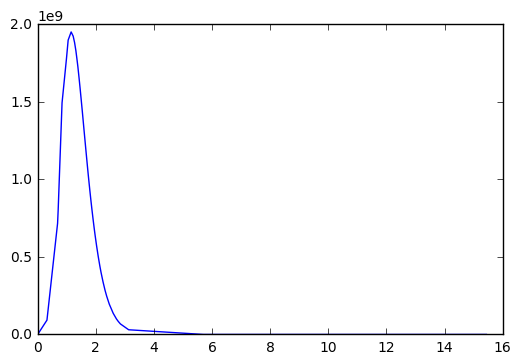

4.94308367737


In [36]:
b_n = beta_new(NClasses, NProperties, cov_n, phi_n)
print b_n

* #### For the Weights

In [21]:
def W_new(v, alpha, NObjects, NClasses):
    
    w_ij = np.zeros((NObjects, NClasses))
    
    for jClass in range(NClasses):
        
        index = v[:] == jClass+1
        
        for Object in range(NObjects):
            
            if index[Object] == True:
                index[Object] = np.logical_not(index[Object])
                rewrite = 1
            else:
                rewrite  = 0
                
                
            y_i = y[index,:]
            n_ij = y_i.shape[0]

            w_ij[Object,jClass] = (n_ij + (alpha/NClasses)) / float(NObjects-1+alpha)
            
            if rewrite == 1:
                index[Object] = np.logical_not(index[Object])
            
    return w_ij


def fAlpha(x, NClasses, n):

    term = (x**(NClasses-3.0/2.0) * np.exp(-1.0/(2.0*x)) * sc.special.gamma(x)) / (sc.special.gamma(n+x))
    
    return np.log(term)
    
def fAlphaPrima(x, NClasses, n):

    return (2.0*NClasses*x - 2.0*x**2.0 * sc.special.polygamma(0,n+x) - 3.0*x + 1.0)/(2.0*x**2.0) + sc.special.polygamma(0,x)


def alpha_new(NClasses, NObjects):
    
    # parameters for the try
    ntry = 0

    while True:

        ntry = ntry+1

        #print 'try: ', ntry

        try:
            
            if ntry>1000:
                break
            
            ars = ARS(fAlpha, fAlphaPrima, xi = [0.1,4,10], lb=0, NClasses=NClasses, n=NObjects)
            samples = ars.draw(1000)
            alphaSample = ars.sampleUpper()
            
            break

        except IndexError:            
            print 'Error in beta sampling! Another try..'
   
    return alphaSample[0]

In [22]:
w_n = W_new(v, priorAlpha, NObjects, NClasses)
print w_n

[[ 0.18        0.14        0.14666667  0.13333333  0.18        0.21333333]
 [ 0.18666667  0.14        0.14        0.13333333  0.18        0.21333333]
 [ 0.18666667  0.13333333  0.14666667  0.13333333  0.18        0.21333333]
 [ 0.18666667  0.14        0.14666667  0.13333333  0.17333333  0.21333333]
 [ 0.18        0.14        0.14666667  0.13333333  0.18        0.21333333]
 [ 0.18        0.14        0.14666667  0.13333333  0.18        0.21333333]
 [ 0.18666667  0.13333333  0.14666667  0.13333333  0.18        0.21333333]
 [ 0.18666667  0.14        0.14666667  0.13333333  0.17333333  0.21333333]
 [ 0.18666667  0.14        0.14666667  0.12666667  0.18        0.21333333]
 [ 0.18666667  0.14        0.14666667  0.13333333  0.17333333  0.21333333]
 [ 0.18666667  0.13333333  0.14666667  0.13333333  0.18        0.21333333]
 [ 0.18666667  0.14        0.14666667  0.13333333  0.17333333  0.21333333]
 [ 0.18666667  0.14        0.14666667  0.13333333  0.18        0.20666667]
 [ 0.18666667  0.14      

In [23]:
a_n = alpha_new(NClasses, NObjects)
print a_n

0.713318825893


* #### For the probability that an object belongs to a class

In [24]:
def probOfClass(y, w, mu, cov, NClasses, NObjects):
    
    T_ij = np.zeros((NObjects, NClasses))

    for Object in range(NObjects):
        
        T_ij_Sumj = np.zeros(NClasses)
        
        for jClass in range(NClasses):
            
            covar = np.linalg.inv(cov[:,:,jClass])
            
            T_ij_Sumj[jClass] = w[Object,jClass] * sc.stats.multivariate_normal.pdf(y[Object,:], mu[jClass,:], covar)
            
        for jClass in range(T_ij_Sumj.shape[0]):
            T_ij[Object,jClass] =   T_ij_Sumj[jClass] / np.sum(T_ij_Sumj)
    
    return T_ij

In [25]:
t_n = probOfClass(y, w_n, mu_n, cov_n, NClasses, NObjects)
print t_n

[[  2.62673332e-012   2.34351046e-019   8.79339548e-008   7.12744751e-009
    9.99999905e-001   2.51822072e-026]
 [  7.14304094e-020   7.34736882e-013   1.20773990e-033   3.03954038e-062
    1.00000000e+000   6.73164723e-011]
 [  1.25021153e-016   1.24130163e-020   8.39610148e-011   2.40858524e-014
    1.00000000e+000   6.12497825e-034]
 [  6.39673901e-021   1.20863413e-011   4.07497627e-062   3.63268695e-072
    1.00000000e+000   6.45641093e-023]
 [  3.51876106e-009   2.48151210e-020   9.36719317e-022   9.99999996e-001
    1.06627679e-028   3.69473247e-025]
 [  2.50215272e-008   7.02015049e-009   9.94906447e-004   5.61764839e-006
    9.98999444e-001   1.48478244e-015]
 [  3.51135855e-006   7.90951315e-009   2.39222364e-004   3.12516908e-006
    9.99754133e-001   9.24498310e-015]
 [  2.43259986e-040   2.88606654e-057   4.55296028e-001   5.44695860e-001
    8.11230566e-006   5.50849502e-079]
 [  1.72680694e-050   5.04139127e-062   6.21413409e-004   9.99378539e-001
    4.71728108e-008   

In [26]:
def V_new(NObjects, probClass):
    
    V = np.zeros((NObjects))
    
    for Object in range(NObjects):
        
        index = np.random.multinomial(1, probClass[Object,:])
        V[Object] = np.where(index==1)[0]+1
        
    return V

In [27]:
v_n = V_new(NObjects, t_n)
print v_n

[ 5.  5.  5.  5.  4.  5.  5.  4.  4.  4.  6.  1.  4.  1.  2.  5.  5.  2.
  4.  5.  5.  4.  5.  1.  5.  1.  2.  1.  5.  1.  2.  1.  4.  1.  2.  4.
  4.  2.  5.  1.  2.  4.  1.  4.  5.  5.  4.  1.  1.  5.  5.  5.  5.  4.
  5.  4.  4.  4.  5.  4.  4.  2.  4.  4.  5.  2.  4.  4.  5.  1.  5.  4.
  5.  4.  4.  5.  4.  4.  4.  1.  4.  4.  3.  4.  5.  4.  4.  5.  4.  4.
  5.  5.  5.  4.  1.  2.  5.  4.  4.  4.  4.  4.  3.  4.  5.  1.  5.  1.
  4.  4.  5.  4.  4.  1.  1.  5.  4.  4.  5.  5.  1.  5.  4.  1.  4.  1.
  3.  4.  1.  5.  4.  5.  1.  1.  1.  5.  4.  5.  5.  4.  1.  2.  5.  4.
  4.  4.  1.  5.  6.  2.]


### Applying the Gibbs sampling

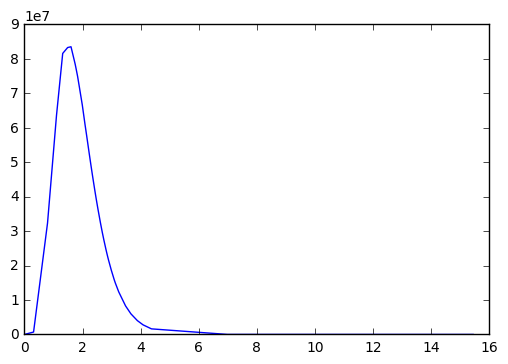

GibbsTry:  1


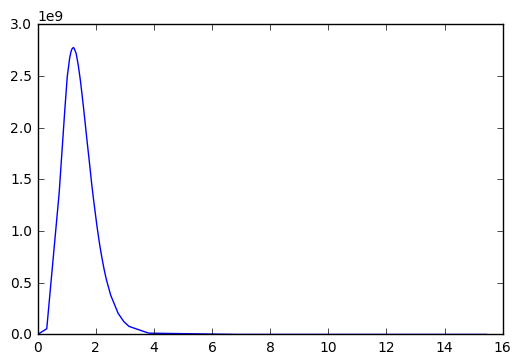

0


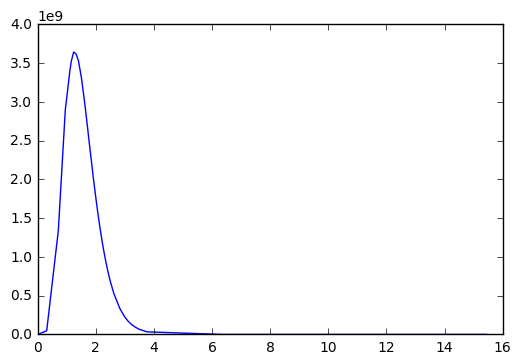

1
Oops! Another try..
GibbsTry:  2


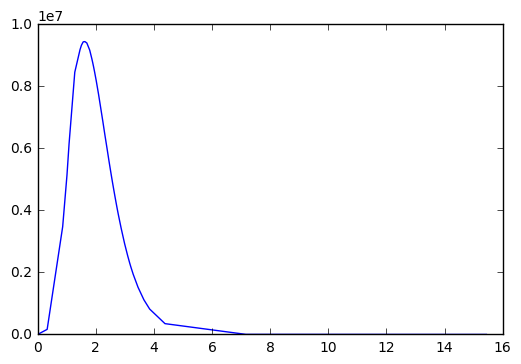

0


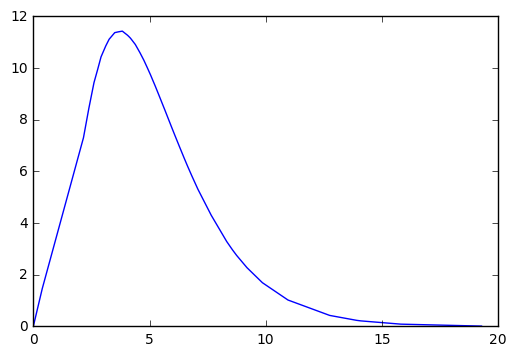

1


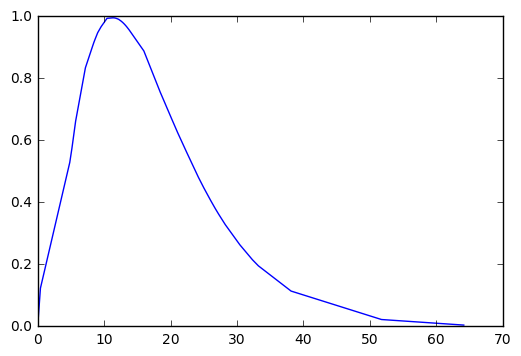

2


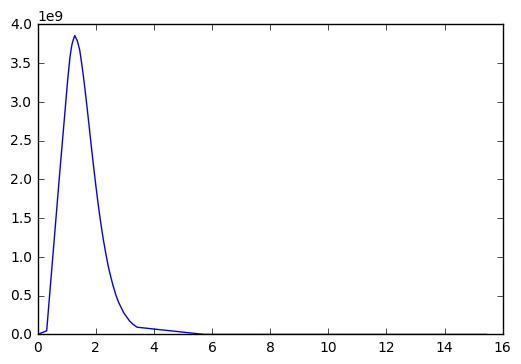

3


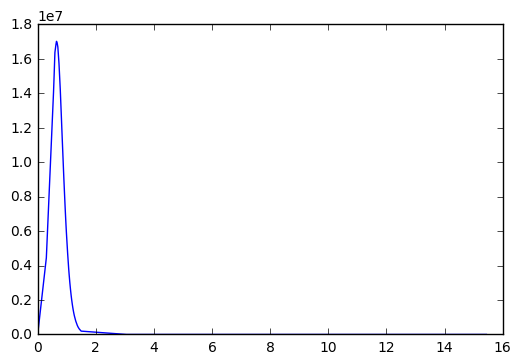

4


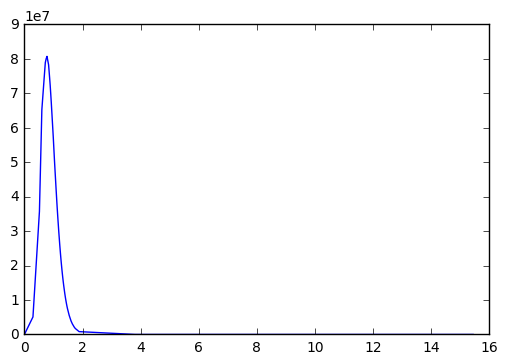

5


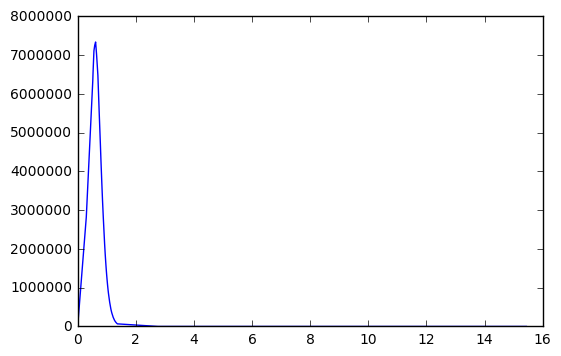

6


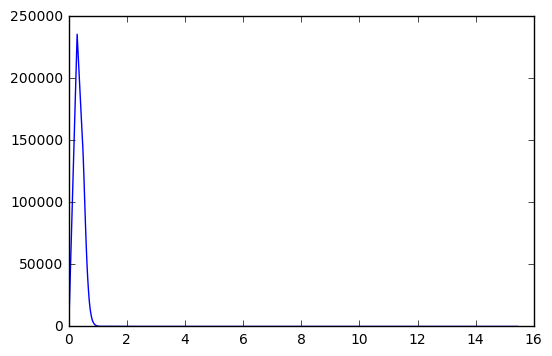

7


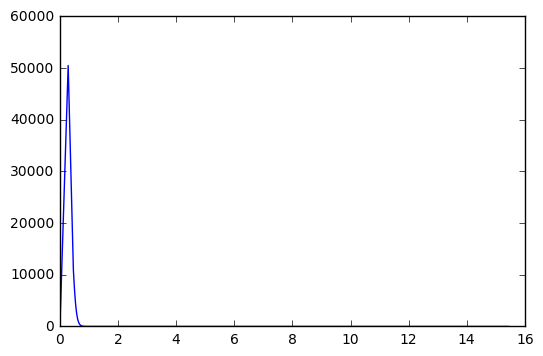

8


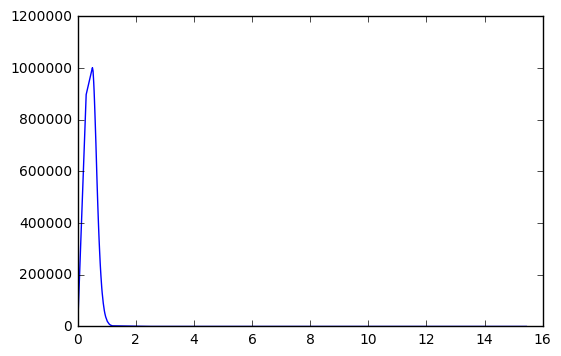

9


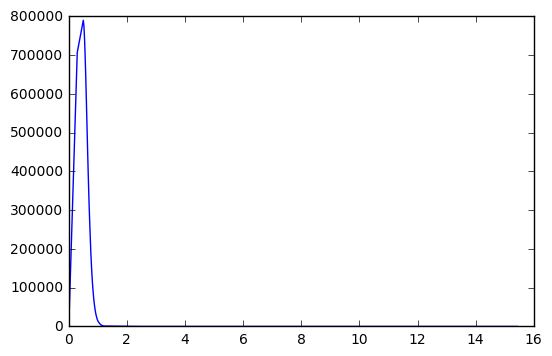

10


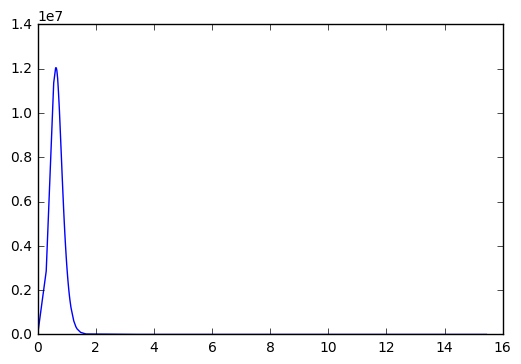

11


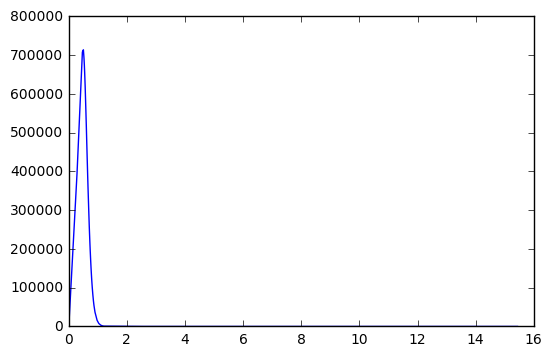

12


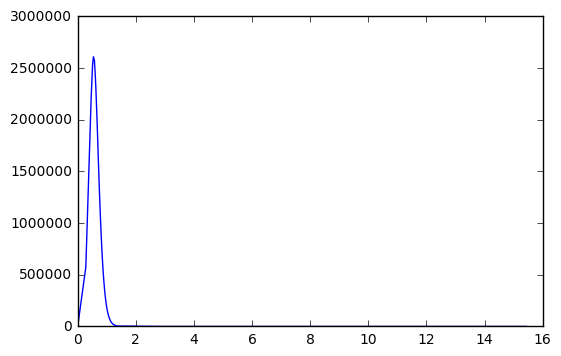

13


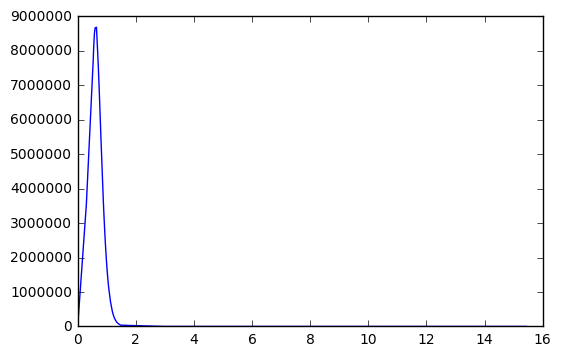

14


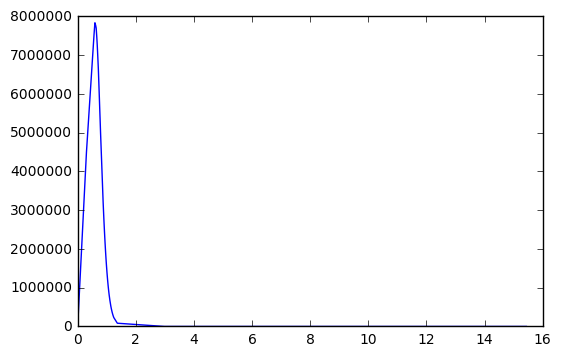

15


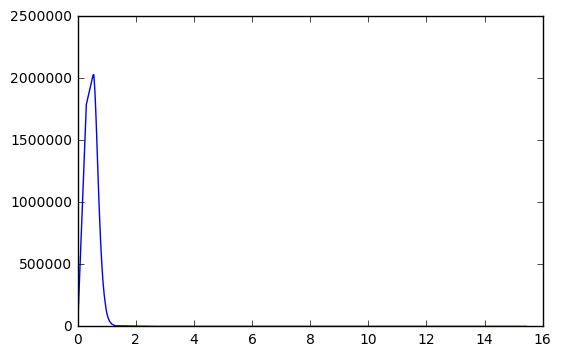

16


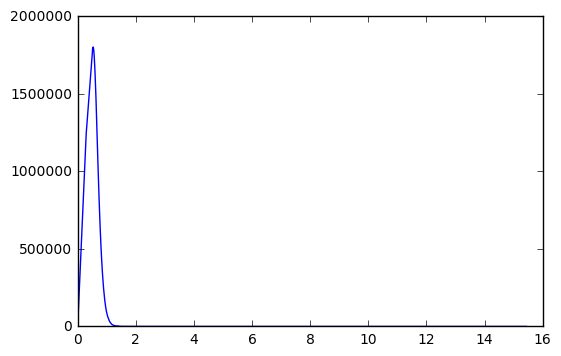

17


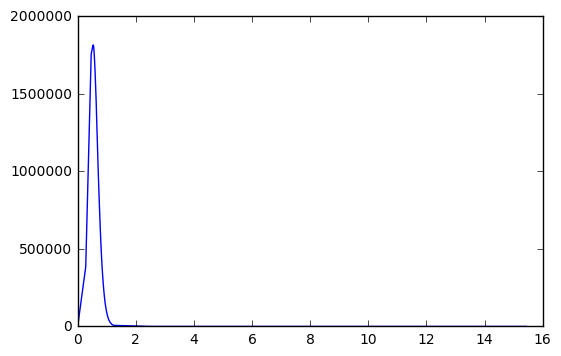

18


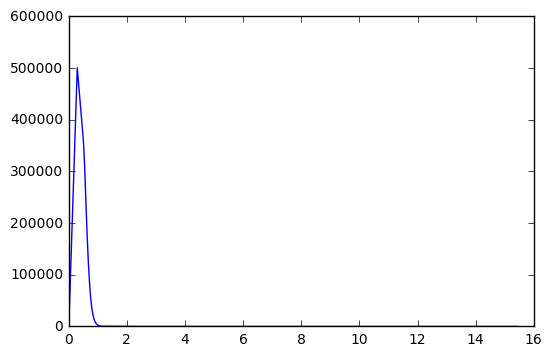

19


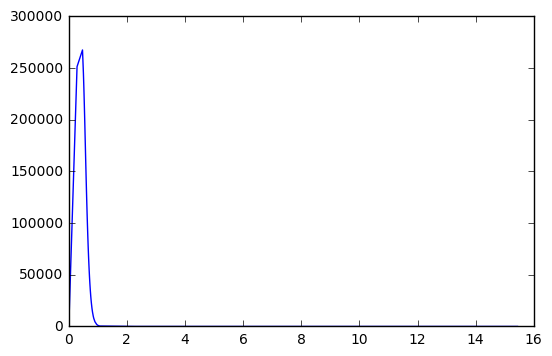

20


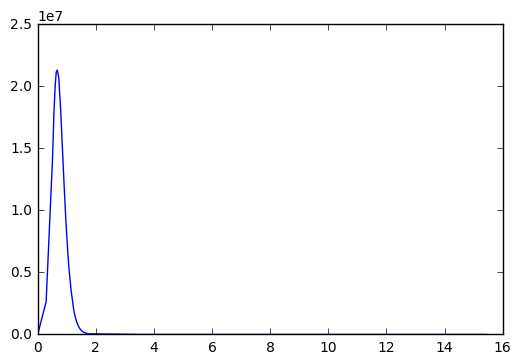

21


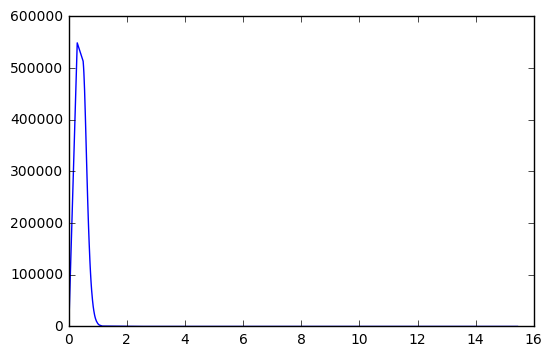

22


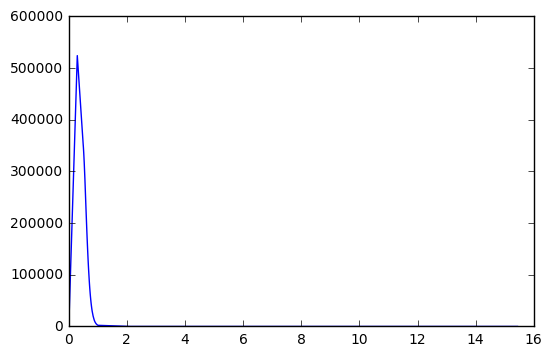

23


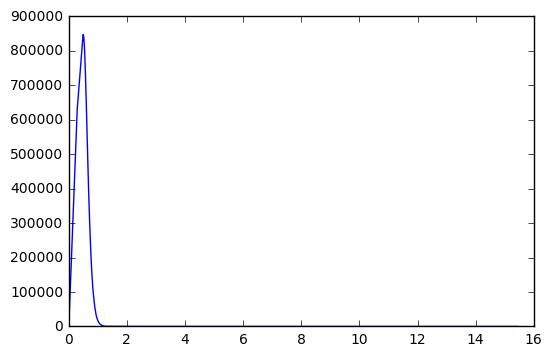

24


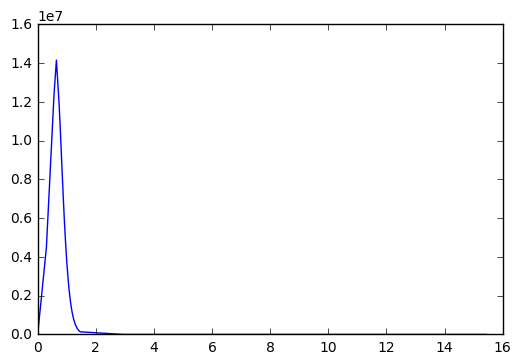

25


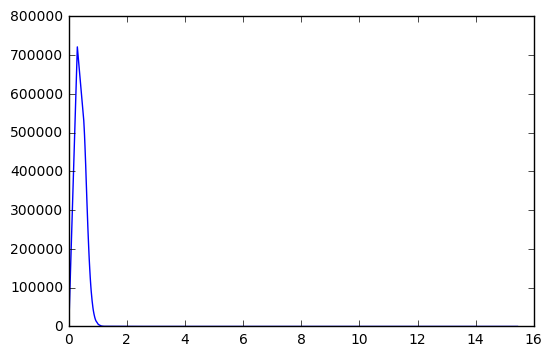

26


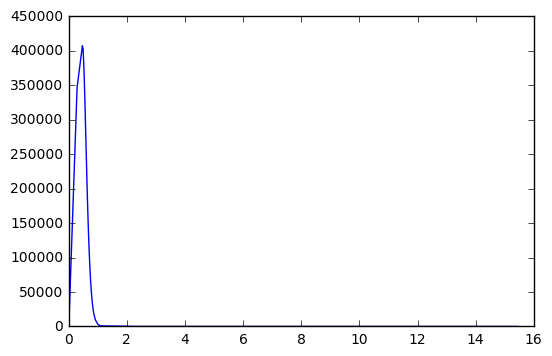

27
Oops! Another try..
GibbsTry:  3


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:134: RuntimeWarning: invalid value encountered in less


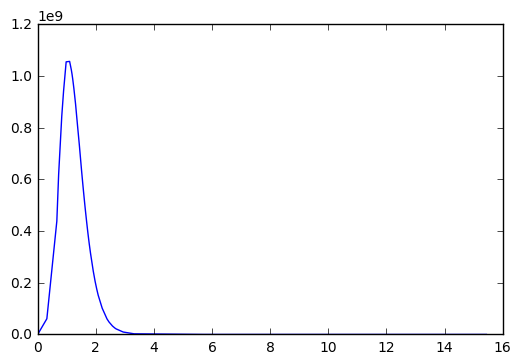

0


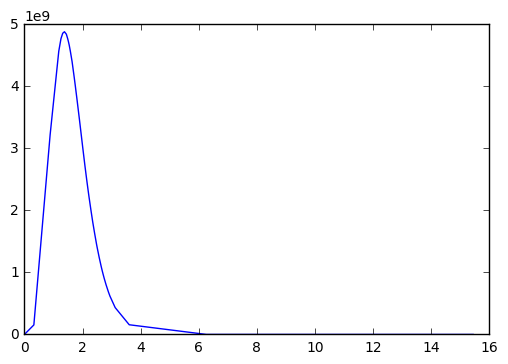

1


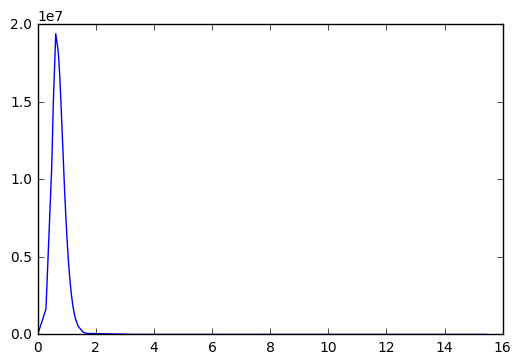

2


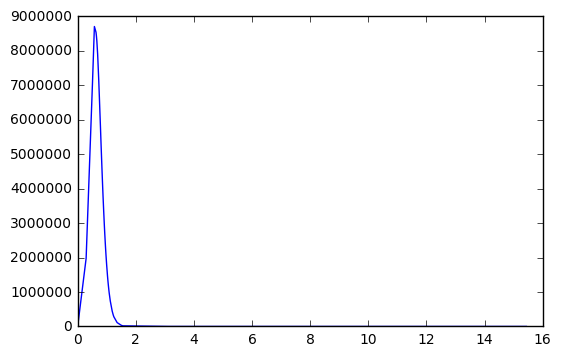

3


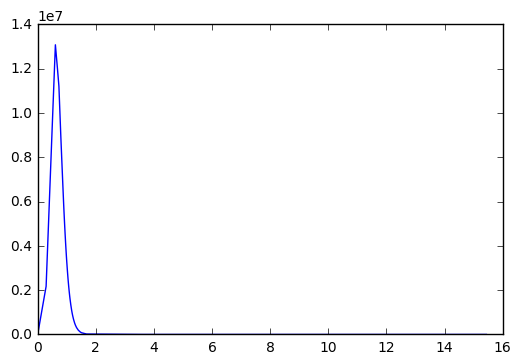

4


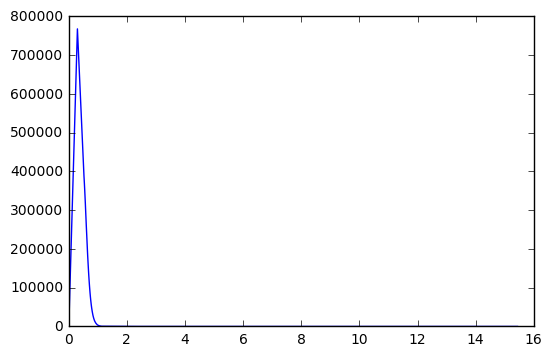

5


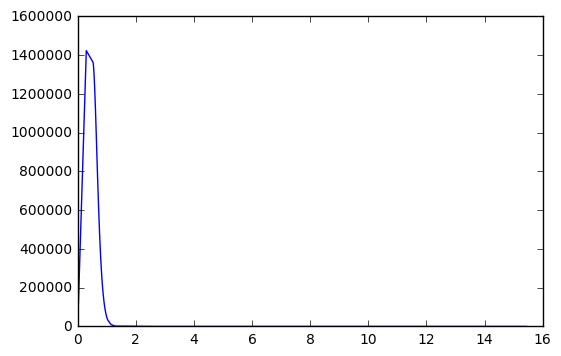

6


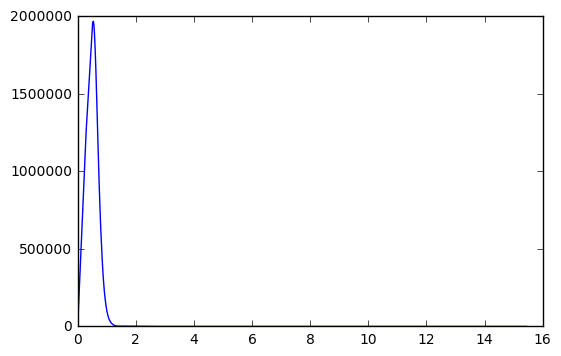

7


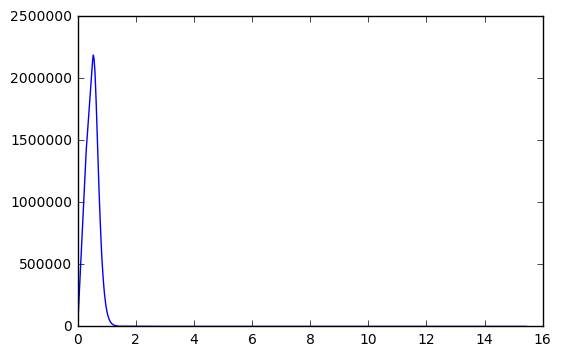

8


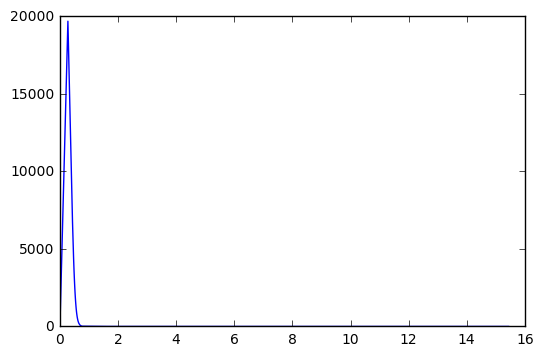

9


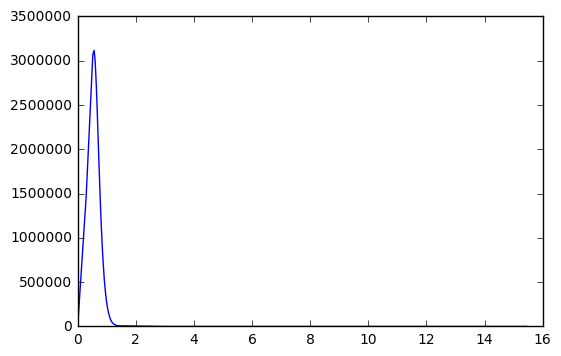

10


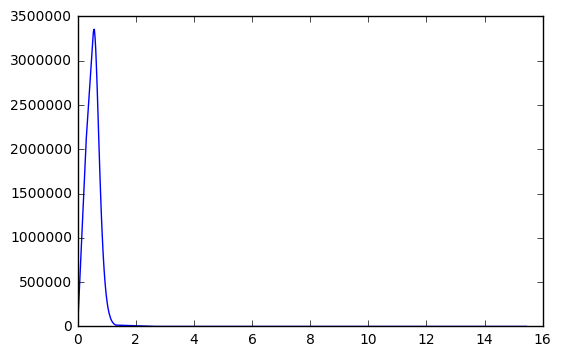

11


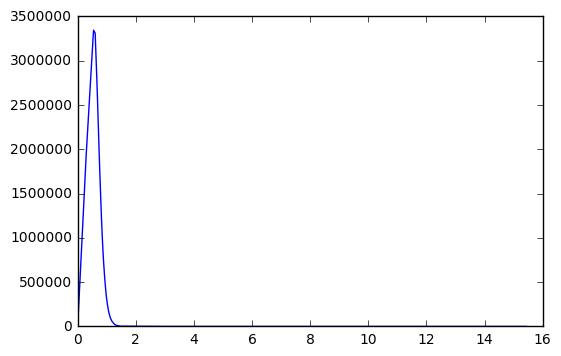

12


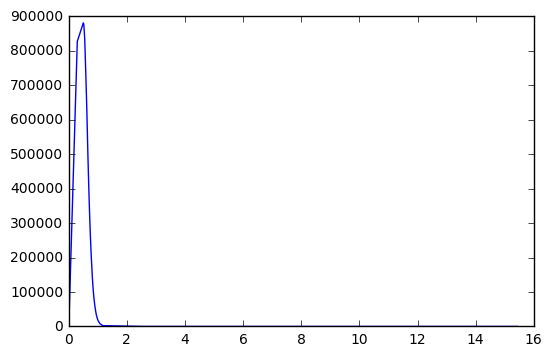

13


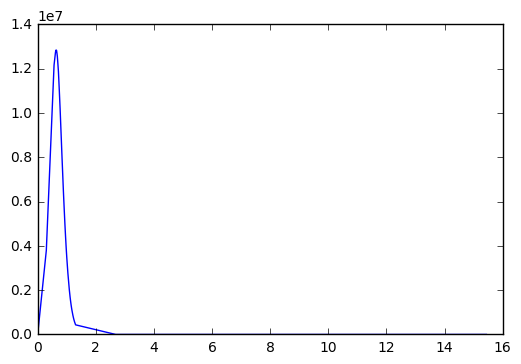

14


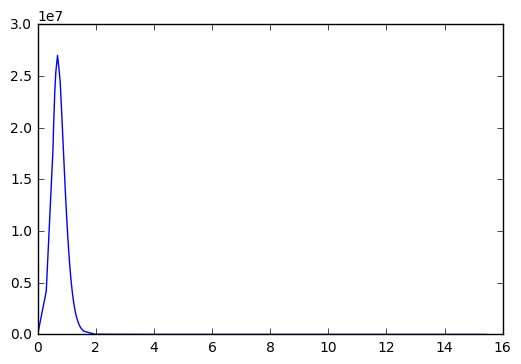

15


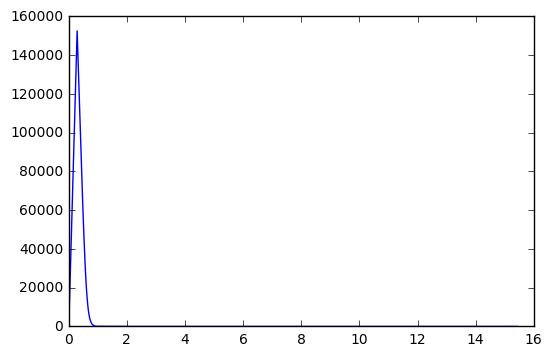

16


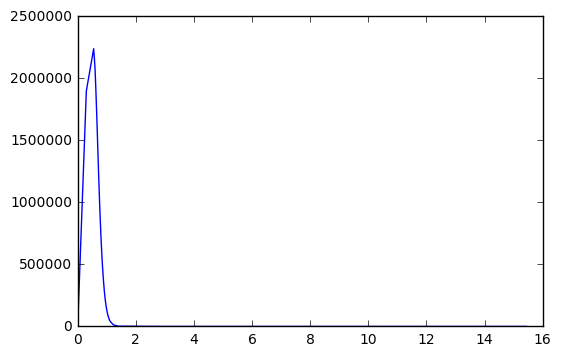

17


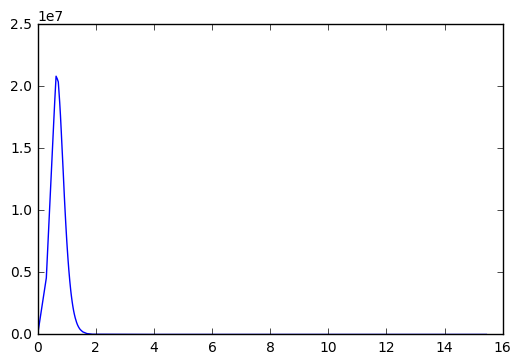

18


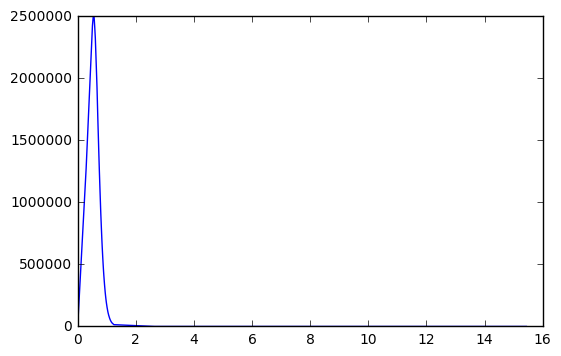

19


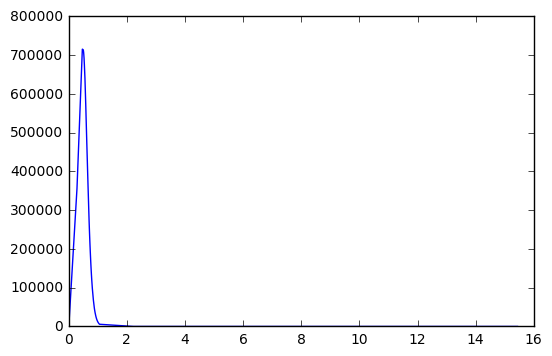

20


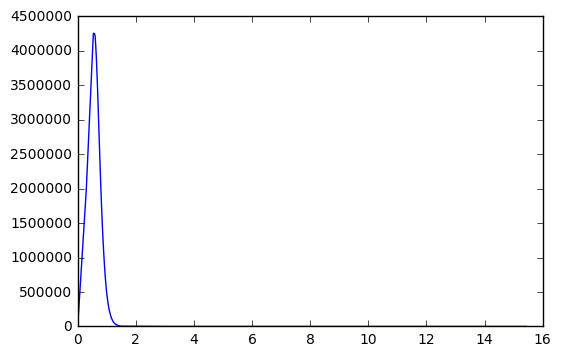

21


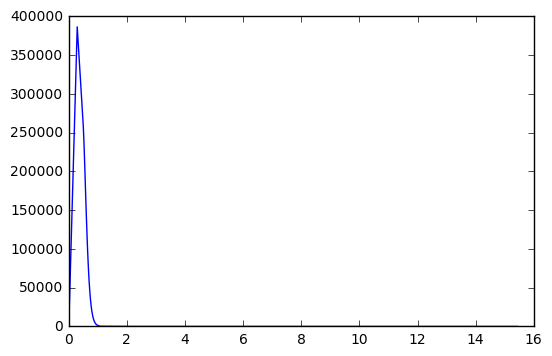

22


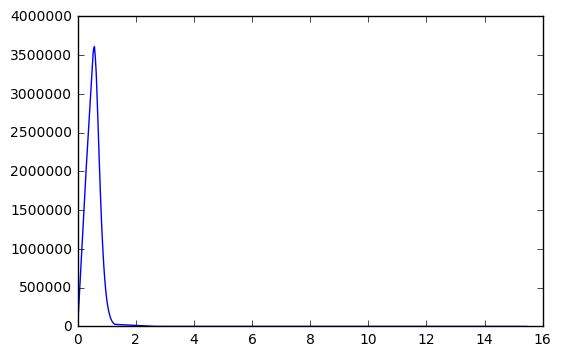

23


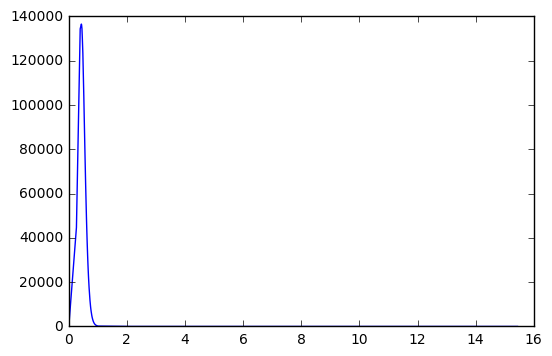

24


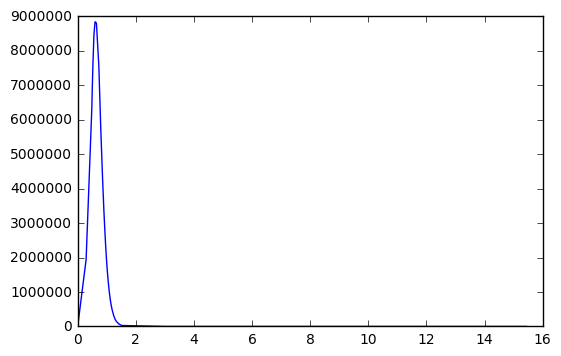

25


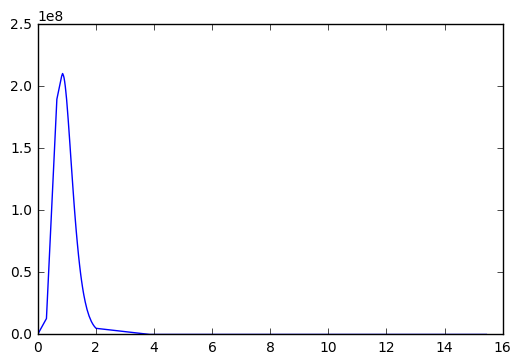

26


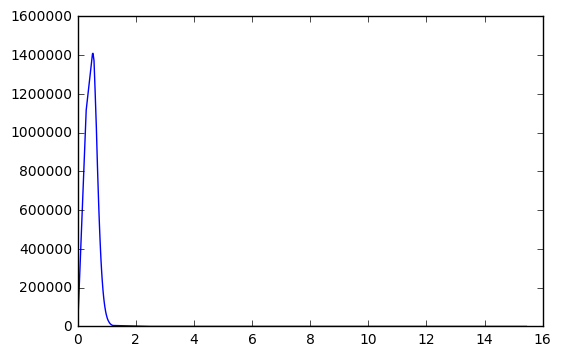

27


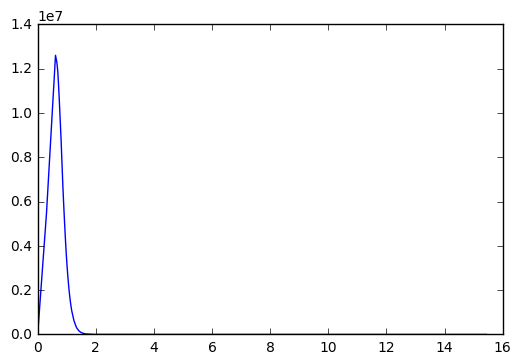

28


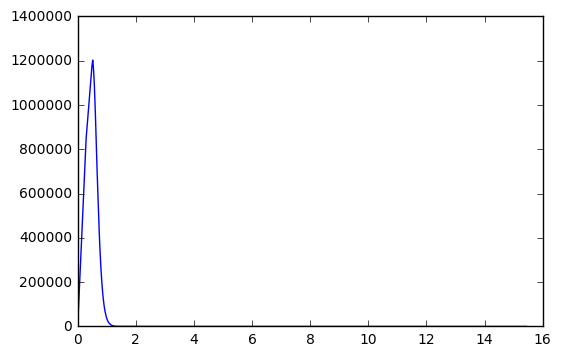

29


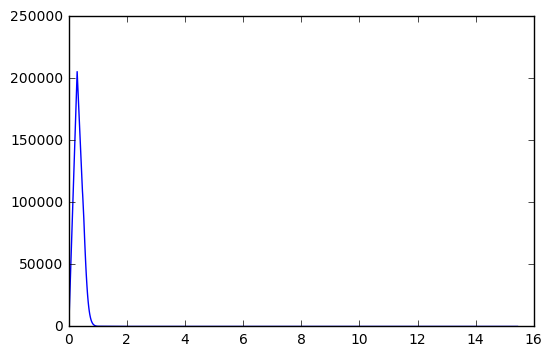

30


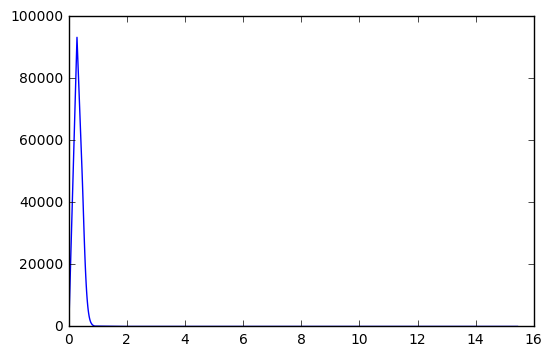

31


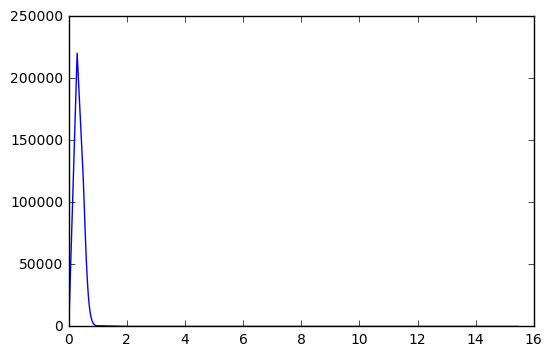

32


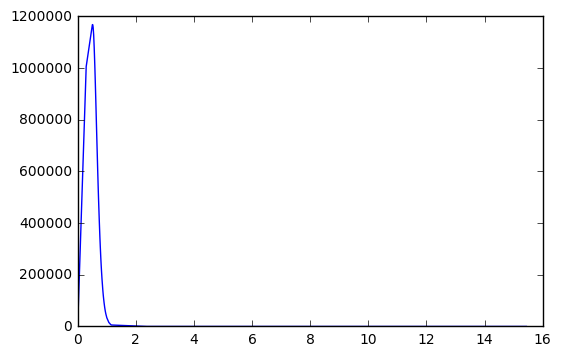

33


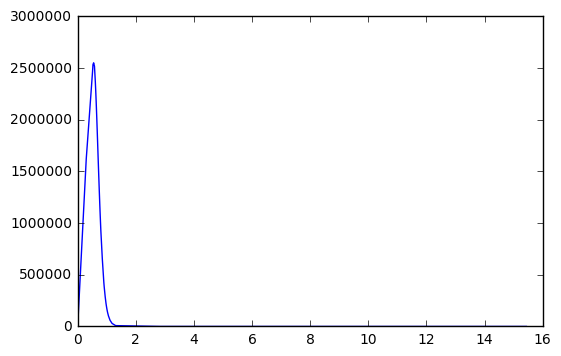

34


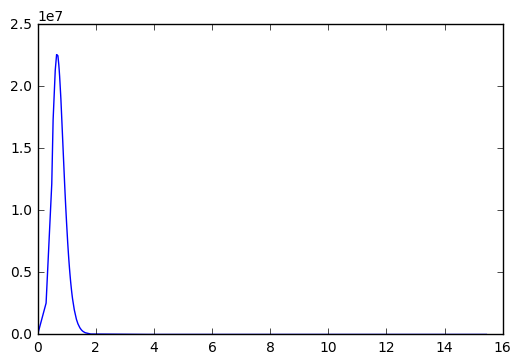

35


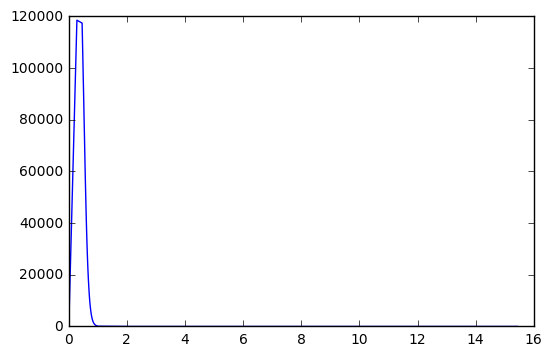

36
Oops! Another try..
GibbsTry:  4


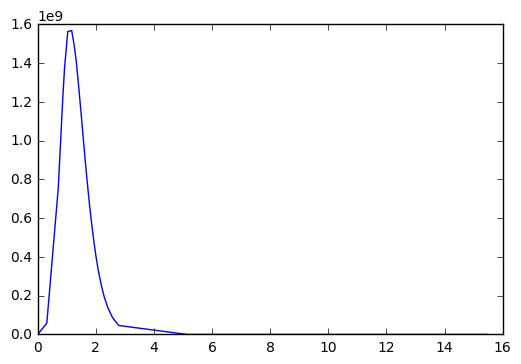

0


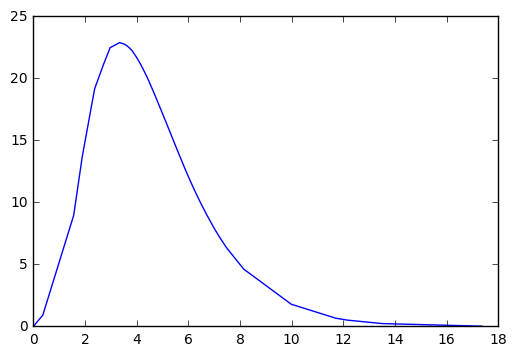

1


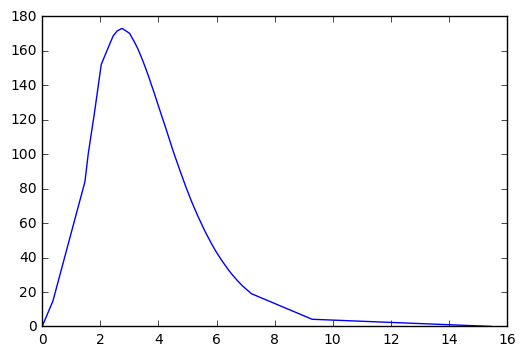

2


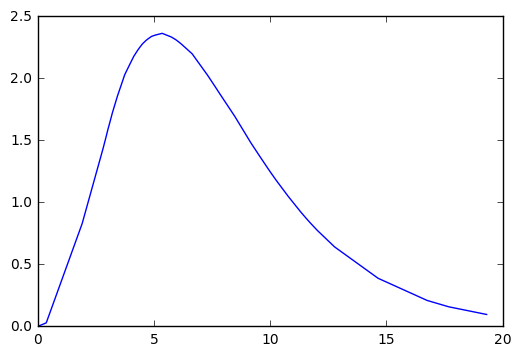

3


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: overflow encountered in double_scalars
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars


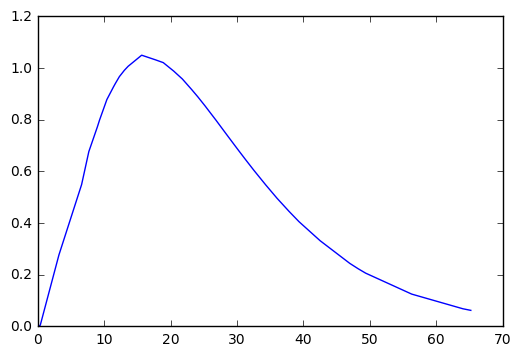

4


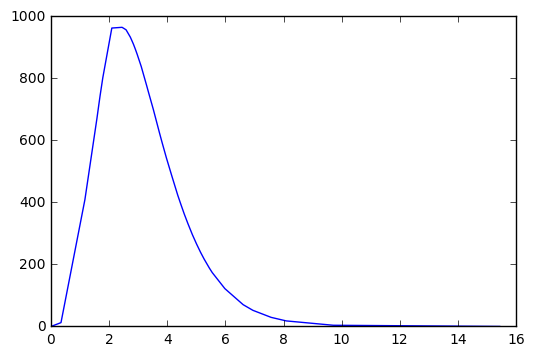

5


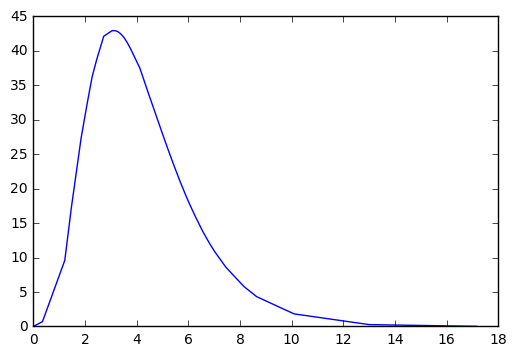

6


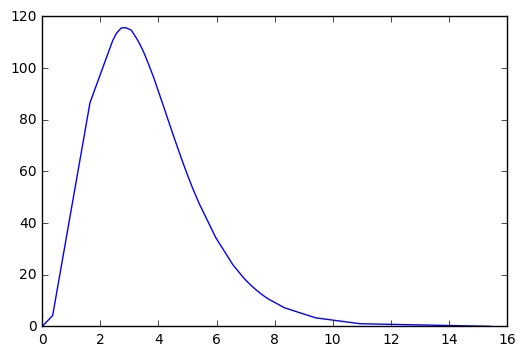

7


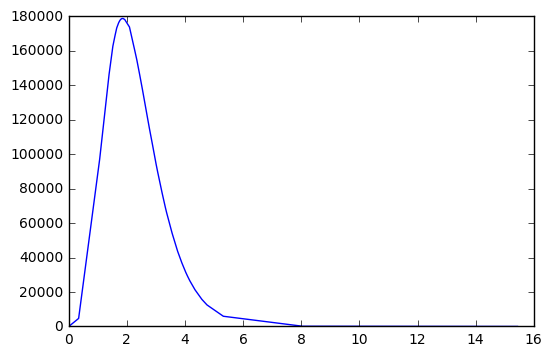

8


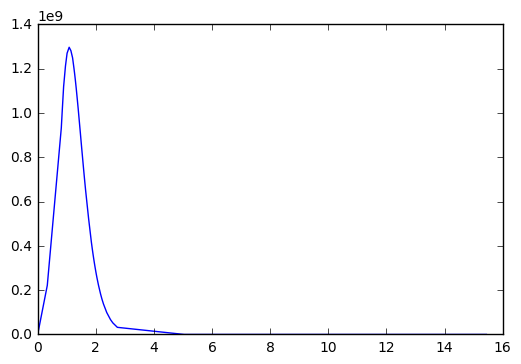

9


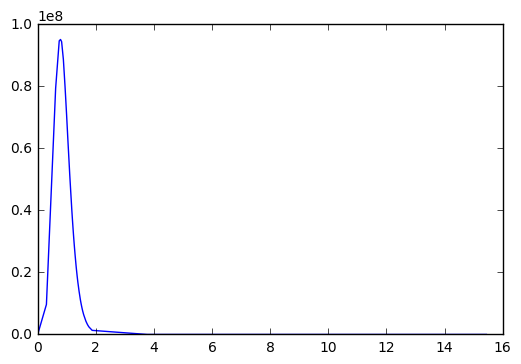

10


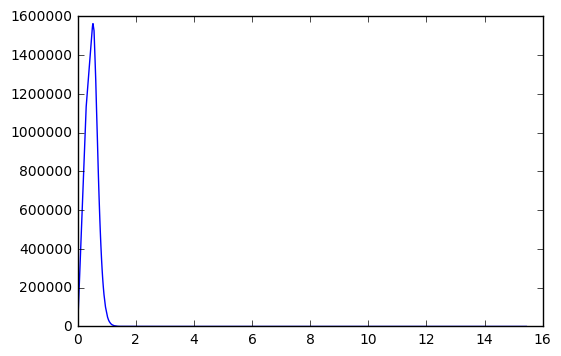

11


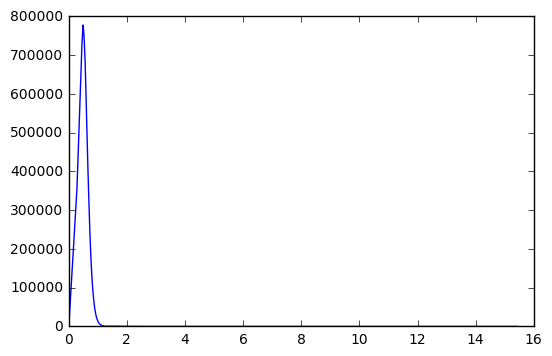

12


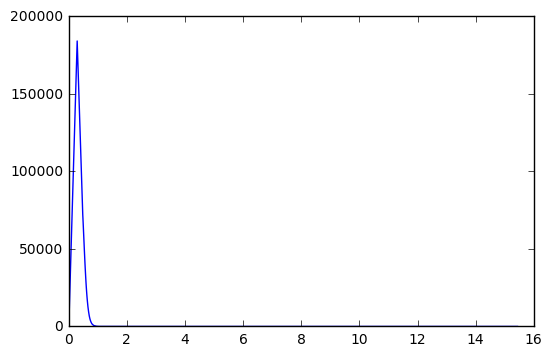

13


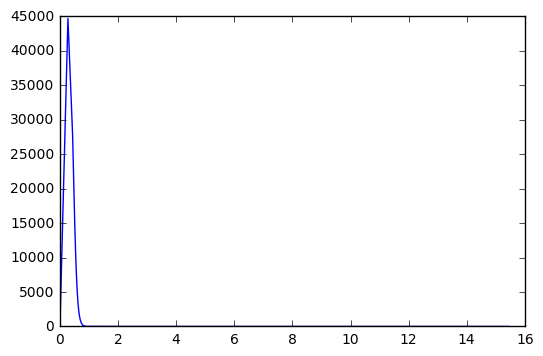

14


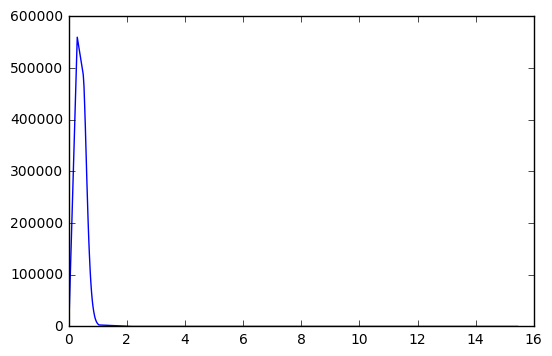

15


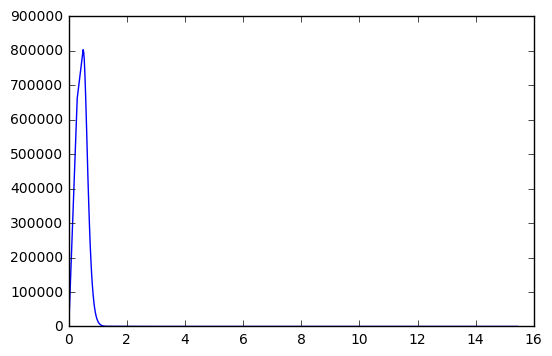

16


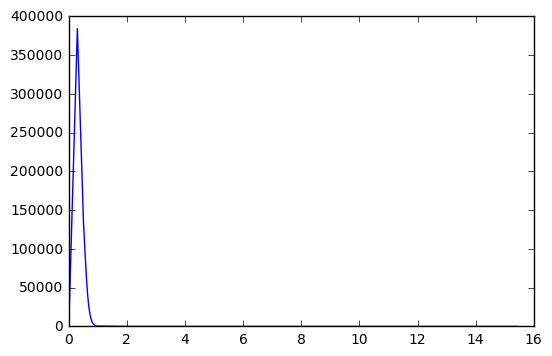

17


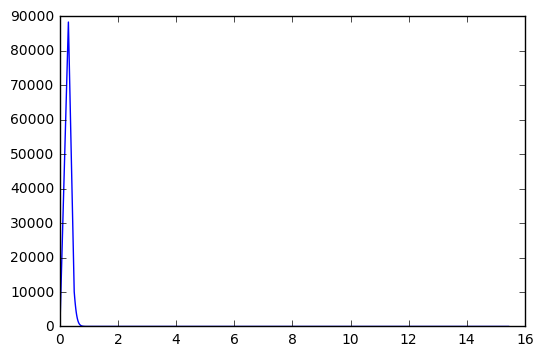

18


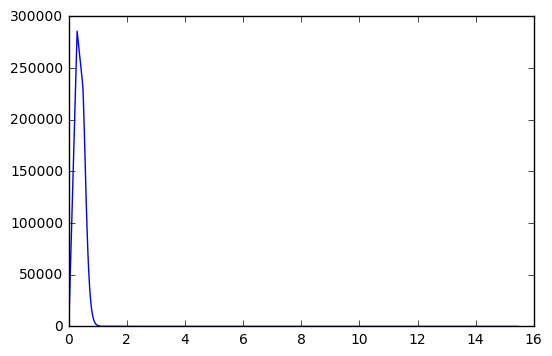

KeyboardInterrupt: 

In [37]:
iteration = 2000
burnIn = 400

# iteration 0
mu_n = Mu_new(y, v, InitCov, InitLambda, InitR, NClasses, NProperties)
l_n = lambda_new(mu_n, priorMu, priorPrec, InitR, NClasses)
R_n = R_new(mu_n, l_n, priorPrec, NClasses, NProperties)
cov_n = cov_new(y, v, mu_n, InitBeta, priorPrec, NClasses, NProperties)
phi_n = phi_new(cov_n, InitBeta, priorPrec, NClasses)
b_n = beta_new(NClasses, NProperties, cov_n, phi_n)
w_n = W_new(v, priorAlpha, NObjects, NClasses)
a_n = alpha_new(NClasses, NObjects)
t_n = probOfClass(y, w_n, mu_n, cov_n, NClasses, NObjects)
v_n = V_new(NObjects, t_n)

## Iterations
# the samples of the paramaters (comment out the undesired the parameter)

cov_post = np.zeros((cov_n.shape[0],cov_n.shape[1],cov_n.shape[2],iteration - burnIn))
phi_post = np.zeros((phi_n.shape[0],phi_n.shape[1],iteration - burnIn))
mu_post = np.zeros((mu_n.shape[0],mu_n.shape[1],iteration - burnIn))
l_post = np.zeros((l_n.shape[0],iteration - burnIn))
R_post = np.zeros((R_n.shape[0],R_n.shape[1],iteration - burnIn))
w_post = np.zeros((w_n.shape[0],w_n.shape[1],iteration - burnIn))
b_post = np.zeros((iteration - burnIn))
a_post = np.zeros((iteration - burnIn))
t_post = np.zeros((t_n.shape[0],t_n.shape[1],iteration - burnIn))
v_post = np.zeros((v_n.shape[0],iteration - burnIn))


# parameters for the try
ntryG = 0

while True:
    
    ntryG = ntryG+1
    
    print 'GibbsTry: ', ntryG
    
    try:
        
        if ntryG>1000:
            break
        
        # iteration 0
        mu_n = Mu_new(y, v, InitCov, InitLambda, InitR, NClasses, NProperties)
        l_n = lambda_new(mu_n, priorMu, priorPrec, InitR, NClasses)
        R_n = R_new(mu_n, l_n, priorPrec, NClasses, NProperties)
        cov_n = cov_new(y, v, mu_n, InitBeta, priorPrec, NClasses, NProperties)
        phi_n = phi_new(cov_n, InitBeta, priorPrec, NClasses)
        b_n = beta_new(NClasses, NProperties, cov_n, phi_n)
        w_n = W_new(v, priorAlpha, NObjects, NClasses)
        a_n = alpha_new(NClasses, NObjects)
        t_n = probOfClass(y, w_n, mu_n, cov_n, NClasses, NObjects)
        v_n = V_new(NObjects, t_n)
        
        for i in range(iteration):

            print i

            # Updateing the parameters
            mu_n = Mu_new(y, v_n, cov_n, l_n, R_n, NClasses, NProperties)
            l_n = lambda_new(mu_n, priorMu, priorPrec, R_n, NClasses)
            R_n = R_new(mu_n, l_n, priorPrec, NClasses, NProperties)
            cov_n = cov_new(y, v_n, mu_n, b_n, phi_n, NClasses, NProperties)
            phi_n = phi_new(cov_n, b_n, priorPrec, NClasses)
            b_n = beta_new(NClasses, NProperties, cov_n, phi_n)
            w_n = W_new(v_n, a_n, NObjects, NClasses)
            a_n = alpha_new(NClasses, NObjects)
            t_n = probOfClass(y, w_n, mu_n, cov_n, NClasses, NObjects)
            v_n = V_new(NObjects, t_n)

            #print cov_n[:,:,0]
            #print phi_n

            if i>burnIn:

                # saving the conditional posteriors samples for the parameters (comment out the undesired parameter)
                v_post[:,i-burnIn] = v_n
                cov_post[:,:,:,i-burnIn] = cov_n
                mu_post[:,:,i-burnIn] = mu_n
                w_post[:,:,i-burnIn] = w_n
                a_post[i-burnIn] = a_n
                b_post[i-burnIn] = b_n
                l_post[:,i-burnIn] = l_n
                phi_post[:,:,i-burnIn] = phi_n
                R_post[:,:,i-burnIn] = R_n
                t_post[:,:,i-burnIn] = t_n
        
        break
            
    except (ValueError, UnboundLocalError, IOError) as err:         
        print 'Oops! Another try..'


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars


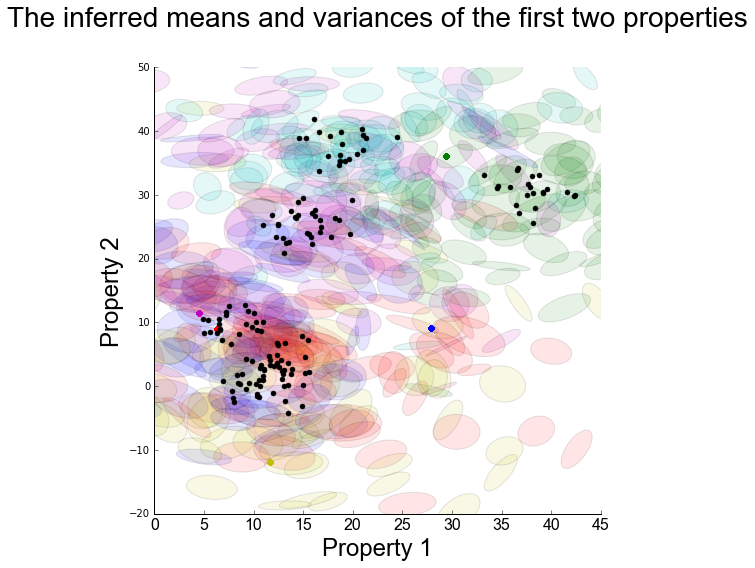

In [162]:
# the figures
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

for i in range(mu_post.shape[2]):
    for j in range(NClasses):

        # the sd with ellipses
        # central point of the error ellipse
        pos = [mu_post[j,0,i],mu_post[j,1,i]]

        # for the angle we need the eigenvectors of the covariance matrix
        w,ve = np.linalg.eig(cov_post[0:2,0:2,j,i])

        # We pick the largest eigen value
        order = w.argsort()[::-1]
        w = w[order]
        ve = ve[:,order]

        # we compute the angle towards the eigen vector with the largest eigen value
        theta = np.degrees(np.arctan(ve[1,0]/ve[0,0]))

        # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
        width, height = 2 * np.sqrt(w)

        # making the ellipse
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta)
        ellip.set_alpha(0.1)
        ellip.set_facecolor(color[j])

        # the mean
        ax1.plot(mu_n[j,0],mu_n[j,1], '.', c=color[j], markersize=sizeMean)
        ax1.add_artist(ellip)
        
ax1.plot(y[:,0],y[:,1], 'k.', markersize=sizeMean)
for label in (ax1.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_ylabel('Property 2', **axis_font)
ax1.set_xlabel('Property 1', **axis_font)
ax1.set_title('The inferred means and variances of the first two properties', y=1.08, **Title_font)
ax1.figure.set_size_inches(plotsize,plotsize)

plt.show()

In [93]:
print 'The inferred mixing proportions: ',np.mean(w_post, axis=1)
print 'The True mixing proportions: 0.166'

The inferred mixing proportions:  [ 0.16258483  0.16010153  0.17389544  0.14645861  0.16140674  0.19492785]
The True mixing proportions: 0.166


In [83]:
for i in range(0,NClasses):
    print ['The Inferred means'], np.mean(mu_post, axis=2)[i,:]
print '------------------'

for i in range(0,NClasses):
    print ['The True mean for Class' + str(i+1)], Mu[i]

['The Inferred means'] [  2.93953168  12.7124291   13.05618522   8.96357276]
['The Inferred means'] [ 27.69668208  32.73527162  33.51504458   8.81321523]
['The Inferred means'] [  8.43839245  11.48966337   0.47927511  37.78273191]
['The Inferred means'] [ 5.7102647   2.14229664  6.85194461  8.8831186 ]
['The Inferred means'] [ 19.47816019  34.02243109  40.20372985  49.43810102]
['The Inferred means'] [ 22.33148251  20.20523691  17.11445971  23.58608225]
------------------
['The True mean for Class1'] [ 5.62350317  1.74271929  7.04422872  8.67078923]
['The True mean for Class2'] [  2.77219531  12.28019846  12.46517118   7.89214103]
['The True mean for Class3'] [ 22.0491188   20.40828755  16.72278955  23.25102071]
['The True mean for Class4'] [ 28.94479676  33.76917817  34.69132822   8.36509903]
['The True mean for Class5'] [  8.22580725  10.9135991    0.09851178  38.34953841]
['The True mean for Class6'] [ 20.15369452  34.13794958  40.64573039  50.4613162 ]


In [84]:
for i in range(0,NClasses):
    print ['the Inferred variances' ]
    print np.mean(cov_post, axis=3)[:,:,j]
print '------------------'
for i in range(0,NClasses):
    print ['the True variance for Class ' + str(i+1)]
    print Cov[i]

['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.59421458]
 [ 1.24284573  3.88443684  1.38748235  0.93200962]
 [ 0.24064534  1.38748235  4.9885372   1.34037046]
 [-1.59421458  0.93200962  1.34037046  5.25004412]]
['the Inferred variances']
[[ 9.41933528  1.24284573  0.24064534 -1.5942

In [117]:
GoodOrder = [2,4,5,1,6,3]
clusters = np.mean(v_post, axis=1)
clusters = np.round(clusters)
infClust = np.zeros(len(clusters))

for i,j in enumerate(GoodOrder):
    index = clusters==i+1
    infClust[index] = j
    
Clustering = y_true[:,4]==infClust
print 'Clustering accuracy: ',np.mean(Clustering)

Clustering accuracy:  0.995


# References:

* Paquet, U. 2008. Bayesian inference for latent variable models. Wolfson College. University of Cambridge. A thesis submitted for the degree of. Doctor of Philosophy.
* Marin, Jean-Michel, Marin Jean-Michel, Mengersen Kerrie, and Christian P. Robert. 2005. “Bayesian Modelling and Inference on Mixtures of Distributions.” In Handbook of Statistics, 459–507.
* Neal, Radford M., and Geoffrey E. Hinton. 1998. “A View of the Em Algorithm That Justifies Incremental, Sparse, and Other Variants.” In Learning in Graphical Models, 355–68.
* Franzén, J. (2006). Bayesian Inference for a Mixture Model using the Gibbs Sampler. Department of Statistics. University of Stockholm.
* Rasmussen, C. (2000). The infinite gaussian mixture model. In Advances in Neural Information Processing Systems 12. Cambridge, MA: MIT Press.